# Mispecification

In [1]:
import sys
import utils_1 as utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
reload(utils)

C:\Users\muham\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<module 'utils_1' from 'D:\\(Akademik)\\(CDT in Mathematics of Random Systems)\\[Broker, Informed, Noise Traders, Filtering Game]\\utils_1.py'>

In [2]:
%load_ext autoreload
%autoreload 2
np.random.seed(100)

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"

font1 = 25
font2 = 23

## 1. Choose the signal filtering strategy & benchmark

In [4]:
# choosing strategy type
# available strategies are "our model", "alternative filter", "naive filter"
# mispecify parameter represents whether the broker mispecifies the informed trader's inventory or not

strategy_type = "our model"
mispecify = False
file_name = f'{strategy_type}'
if mispecify:
    file_name += f' (mispecified inventory)'
    
alpha_est_name = {"our model": r'$\hat{\alpha}_t$',
                  "alternative filter": r'$\hat{\alpha}^{alt}_t$',
                  "naive filter": r'$\hat{\alpha}^{naive}_t$'}

## 2. Set the parameters & functions involved

In [5]:
kappa_alpha_base = 5.
sigma_alpha_base = 1.
theta_B_base = 10.
sigma_B_base = 60.

params_env = {'b': 1e-03, 'alpha0': 0, 'kappa_alpha': kappa_alpha_base, 'sigma_alpha': sigma_alpha_base, 
              'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

env = utils.environment(**params_env)

params_uninf = {'kappa' : 15., 'nu0' : 0., 'sigma' : 100., 'k' : 2e-03}

uninf_trader = utils.uninformed(**params_uninf)

scale_ivp = 1 # change this to change the scale in solving ivp for V_B

nsims = 10_000

W = env.simulate_BM_with_drift(x0=0, mu=0, sigma=1, nsims=nsims)

seed_alpha = 20240820
np.random.seed(seed_alpha)
alpha = env.simulate_alpha(nsims = nsims)
nu_U = uninf_trader.simulate_uninformed_flow(env, nsims=nsims)

In [6]:
np.random.seed(seed_alpha)
alpha_1 = env.simulate_alpha(nsims = nsims)

In [7]:
alpha - alpha_1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
err = 0.5

param_list_name = ['kappa_alpha', 'sigma_alpha', 'theta_B', 'sigma_B']
err_name = [f'+{err*100:1.0f}%', f'-{err*100:1.0f}%']
ratio_list = np.array([1 + err, 1 - err])

kappa_alpha_list = dict(zip(err_name, kappa_alpha_base*ratio_list))
sigma_alpha_list = dict(zip(err_name, sigma_alpha_base*ratio_list))
theta_B_list = dict(zip(err_name, theta_B_base*ratio_list))
sigma_B_list = dict(zip(err_name, sigma_B_base*ratio_list))

param_list_base = dict(zip(param_list_name, [kappa_alpha_base,
                                            sigma_alpha_base,
                                            theta_B_base,
                                            sigma_B_base]))

param_list_val = dict(zip(param_list_name, [kappa_alpha_list,
                                            sigma_alpha_list,
                                            theta_B_list,
                                            sigma_B_list]))

In [9]:
param_list_val

{'kappa_alpha': {'+50%': 7.5, '-50%': 2.5},
 'sigma_alpha': {'+50%': 1.5, '-50%': 0.5},
 'theta_B': {'+50%': 15.0, '-50%': 5.0},
 'sigma_B': {'+50%': 90.0, '-50%': 30.0}}

In [10]:
param_list_base

{'kappa_alpha': 5.0, 'sigma_alpha': 1.0, 'theta_B': 10.0, 'sigma_B': 60.0}

In [11]:
err_name

['+50%', '-50%']

In [12]:
for err_name, param_val in param_list_val['kappa_alpha'].items():
    print(err_name, param_val)

+50% 7.5
-50% 2.5


## 4. Simulate the informed trader & broker's strategies

In [13]:
import simulations_1 as simulations

## 4a. Mispecification from broker's POV

In [14]:
sim_collections = dict(zip(param_list_name, [[] for param in param_list_name]))
inf_trader_collections = dict(zip(param_list_name, [[] for param in param_list_name]))
inf_trader_misp_collections = dict(zip(param_list_name, [[] for param in param_list_name]))
broker_collections = dict(zip(param_list_name, [[] for param in param_list_name]))

In [15]:
for param_name in param_list_name:
    
    for err_name, param_val in param_list_val[param_name].items():
        
        param = param_list_base.copy()
        param[param_name] = param_val

        params_env_misp = {'b': 1e-03, 'alpha0': 0, 'kappa_alpha': param['kappa_alpha'], 'sigma_alpha': param['sigma_alpha'], 
                           'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

        env_misp = utils.environment(**params_env_misp)

        scale_ivp = 1 # change this to change the scale in solving ivp for V_B

        params_inf = {'env': env, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                          'sigma_B' : sigma_B_base, 'mu_B' : 0., 'theta_B' : theta_B_base, 'sigma_0' : 0, 'c_importance' : 1}

        params_inf_misp = {'env': env_misp, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                          'sigma_B' : param['sigma_B'], 'mu_B' : 0., 'theta_B' : param['theta_B'], 'sigma_0' : 0, 'c_importance' : 1}

        inf_trader =  utils.informed(**params_inf)

        inf_trader_misp =  utils.informed(**params_inf_misp)

        inf_trader_collections[param_name].append(inf_trader)

        inf_trader_misp_collections[param_name].append(inf_trader_misp)

        params_broker = {'env': env_misp, 'inf': inf_trader_misp, 'uninf': uninf_trader,
                         'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-01, 'beta1': 1e-03, 'rho0': 1e-03, 'rho1': 1e-05, 
                         'sigma_B': inf_trader_misp.sigma_B, 'mu_B': inf_trader_misp.mu_B, 'theta_B': inf_trader_misp.theta_B, 
                         'sigma_0': 0, 'scale_ivp': scale_ivp}

        broker = utils.broker(**params_broker)

        broker_collections[param_name].append(broker)

        model = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                                       W, alpha, nu_U, 
                                       strategy = strategy_type, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

        sim_collections[param_name].append(model)

        benchmarks = dict.fromkeys([f'benchmark {i+1}' for i in range(3)])
        outperform = dict.fromkeys([f'benchmark {i+1}' for i in range(3)])

        print(f"{param_name} ({err_name})")
        print(f'{param}\n')

        for i, bench in enumerate(benchmarks.keys()):
            benchmarks[bench] = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                                                       W, alpha, nu_U, 
                                                       strategy = bench, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)
            outperform[bench] = 1e06*((model.Portfolio_B - benchmarks[bench].Portfolio_B)/benchmarks[bench].total_value_traded).reshape((-1,))

            t_stat, p_value = stats.ttest_1samp(outperform[bench], 0, alternative='greater')
            print(f'Outperformance: {outperform[bench].mean():.1f} ({outperform[bench].std():.1f})')
            print(f"T-test for outperformance w.r.t benchmark {i+1}")
            print("T statistic:", t_stat)
            print("P-value:", p_value, "\n")
            
        print('-----------------------------------------------')

kappa_alpha (+50%)
{'kappa_alpha': 7.5, 'sigma_alpha': 1.0, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: -11.4 (572.0)
T-test for outperformance w.r.t benchmark 1
T statistic: -1.994469780107925
P-value: 0.9769360785744204 

Outperformance: 37.7 (358.0)
T-test for outperformance w.r.t benchmark 2
T statistic: 10.535704931800703
P-value: 4.036781135963498e-26 

Outperformance: 87.6 (694.9)
T-test for outperformance w.r.t benchmark 3
T statistic: 12.60237126862133
P-value: 1.9272050799480758e-36 

-----------------------------------------------
kappa_alpha (-50%)
{'kappa_alpha': 2.5, 'sigma_alpha': 1.0, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: -12.2 (569.1)
T-test for outperformance w.r.t benchmark 1
T statistic: -2.1350089767699134
P-value: 0.9836077428977641 

Outperformance: 36.9 (364.4)
T-test for outperformance w.r.t benchmark 2
T statistic: 10.137864927144294
P-value: 2.4511675271369786e-24 

Outperformance: 87.0 (692.6)
T-test for outperformance w.r.t benchmark 3
T

## Mispecification from informed trader's POV

In [14]:
sim_collections_1 = dict(zip(param_list_name, [[] for param in param_list_name]))
inf_trader_collections_1 = dict(zip(param_list_name, [[] for param in param_list_name]))

In [15]:
param_list_val['kappa_alpha'].items()

dict_items([('+50%', 7.5), ('-50%', 2.5)])

In [16]:
param_list_name

['kappa_alpha', 'sigma_alpha', 'theta_B', 'sigma_B']

In [17]:
for param_name in param_list_name:
    
    params_inf_br = {'env': env, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                  'sigma_B' : sigma_B_base, 'mu_B' : 0., 'theta_B' : theta_B_base, 'sigma_0' : 0, 'c_importance' : 1}
    
    inf_trader_br =  utils.informed(**params_inf_br)
    
    params_broker = {'env': env, 'inf': inf_trader_br, 'uninf': uninf_trader,
                     'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-01, 'beta1': 1e-03, 'rho0': 1e-03, 'rho1': 1e-05, 
                     'sigma_B': inf_trader_br.sigma_B, 'mu_B': inf_trader_br.mu_B, 'theta_B': inf_trader_br.theta_B, 
                     'sigma_0': 0, 'scale_ivp': scale_ivp}

    broker = utils.broker(**params_broker)
    
    benchmark = simulations.simulation(env, inf_trader_br, uninf_trader, broker, 
                                       W, alpha, nu_U, 
                                       strategy = strategy_type, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)
    
    for err_name, param_val in param_list_val[param_name].items():
        
        param = param_list_base.copy()
        param[param_name] = param_val

        params_env_misp = {'b': 1e-03, 'alpha0': 0, 'kappa_alpha': param['kappa_alpha'], 'sigma_alpha': param['sigma_alpha'], 
                           'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

        env_misp = utils.environment(**params_env_misp)

        scale_ivp = 1 # change this to change the scale in solving ivp for V_B
        
        params_inf = {'env': env_misp, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                      'sigma_B' : param['sigma_B'], 'mu_B' : 0., 'theta_B' : param['theta_B'], 'sigma_0' : 0, 'c_importance' : 1}

        inf_trader =  utils.informed(**params_inf)

        inf_trader_collections_1[param_name].append(inf_trader)

        model = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                                       W, alpha, nu_U, 
                                       strategy = strategy_type, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

        sim_collections_1[param_name].append(model)

        outperform = 1e06*((model.Portfolio_I - benchmark.Portfolio_I)/benchmark.total_value_traded).reshape((-1,))

        t_stat, p_value = stats.ttest_1samp(outperform, 0, alternative='greater')
        print(f"{param_name} ({err_name})")
        print(f'{param}\n')
        print(f'Outperformance: {outperform.mean():.1f} ({outperform.std():.1f})')
        print(f"T-test for outperformance")
        print("T statistic:", t_stat)
        print("P-value:", p_value, "\n")
            
        print('-----------------------------------------------')

kappa_alpha (+50%)
{'kappa_alpha': 7.5, 'sigma_alpha': 1.0, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: -0.9 (177.0)
T-test for outperformance
T statistic: -0.5107436363277836
P-value: 0.695229071632451 

-----------------------------------------------
kappa_alpha (-50%)
{'kappa_alpha': 2.5, 'sigma_alpha': 1.0, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: -21.4 (343.6)
T-test for outperformance
T statistic: -6.215283377757733
P-value: 0.9999999997336194 

-----------------------------------------------
sigma_alpha (+50%)
{'kappa_alpha': 5.0, 'sigma_alpha': 1.5, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: 0.0 (0.0)
T-test for outperformance
T statistic: 1.0882357842687518
P-value: 0.13825863001498429 

-----------------------------------------------
sigma_alpha (-50%)
{'kappa_alpha': 5.0, 'sigma_alpha': 0.5, 'theta_B': 10.0, 'sigma_B': 60.0}

Outperformance: -0.0 (0.0)
T-test for outperformance
T statistic: -1.0779798092327373
P-value: 0.8594656142511294 

----------

In [19]:
param_list_base

{'kappa_alpha': 2.5, 'sigma_alpha': 0.5, 'theta_B': 5.0, 'sigma_B': 30.0}

## Externalisation & Stressing

In [14]:
import utils as utils_old
import simulations as simulations_old

In [15]:
scale_ivp = 100000 # change this to change the scale in solving ivp for V_B

params_inf = {'env': env, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
              'sigma_B' : 60., 'mu_B' : 0., 'theta_B' : 10., 'sigma_0' : 0}

inf_trader =  utils_old.informed(**params_inf)

params_broker = {'env': env, 'inf': inf_trader, 'uninf': uninf_trader,
                 'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-01, 'beta1': 1e-03, 'rho0': 1e-03, 'rho1': 1e-05, 
                 'sigma_B': inf_trader.sigma_B, 'mu_B': inf_trader.mu_B, 'theta_B': inf_trader.theta_B, 
                 'sigma_0': 0, 'scale_ivp': scale_ivp}

broker = utils_old.broker(**params_broker)

D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:213: RuntimeWarning: divide by zero encountered in divide
  GF0 = -(env.b/env.sigma_s)**2 * V_I - f3/2 - (env.b/(2*inf.k*f2))
D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:227: RuntimeWarning: invalid value encountered in divide
  GF6 = -(dGF3 * (GF3 + env.corr*GF4) + dGF3 * (env.corr * GF3 + GF4))/(GF5**2)
D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:230: RuntimeWarning: invalid value encountered in divide
  GF7 = GF_alpha/GF5
D:\(Akademik)\(CDT in Mathematics of Random Systems)\[Broker, Informed, Noise Traders, Filtering Game]\utils.py:233: RuntimeWarning: invalid value encountered in divide
  kF = (GF3 + env.corr * GF4)/GF5


In [16]:
strategy = "naive filter"

In [17]:
model_base = simulations_old.simulation(env, inf_trader, uninf_trader, broker, 
                                   W, alpha, nu_U, 
                                   strategy = strategy, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

In [18]:
def auxF(x, tol=1e-10):
    return np.maximum(x,tol)*(x>=0) + np.minimum(x,-tol)*(x<0)

In [19]:
eps = 1e-1
#ratio_IB = (eps + np.abs(nu_I[1:]))/(eps + np.abs(nu_B[1:])) #np.exp(nu_I)/(np.exp(nu_B) + np.exp(nu_I) )
ratio_IB_base = auxF(model_base.nu_I[1:, :])/auxF(model_base.nu_B[1:, :]) #np.exp(nu_I)/(np.exp(nu_B) + np.exp(nu_I) )
ratio_IB_base_median = np.median(ratio_IB_base,axis=1)
#ratio_iI = (eps + np.abs(nu_I[1:]))/(eps + np.abs(nu_iI[1:]))#np.exp(nu_iI)/(np.exp(nu_iI) + np.exp(nu_I) )

qtl_IB_base = np.quantile(ratio_IB_base,[0.05,0.95], axis=1)
#qtl_iI = np.quantile(ratio_iI,[0.05,0.95], axis=1)

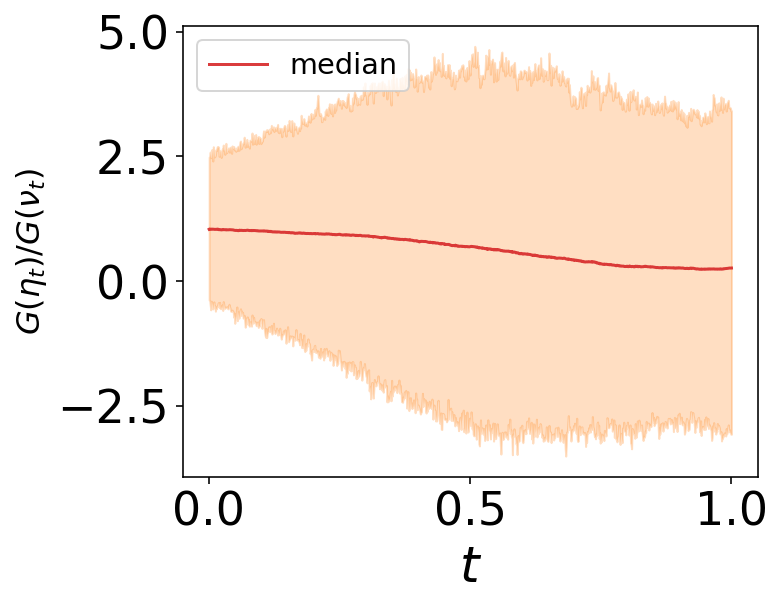

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

ax.plot(env.timesteps[1:], np.median(ratio_IB_base,axis=1),  'tab:red', alpha = 0.9, label = 'median')
ax.fill_between(env.timesteps[1:].reshape(-1,),qtl_IB_base[0],qtl_IB_base[-1],alpha=0.25, color='tab:orange')
ax.legend(loc = 'upper left')
ax.set_ylabel(r'$G\left(\eta_t\right) / G\left(\nu_t\right)$', fontsize = 16)
ax.set_xlabel(r'$t$', fontsize = 16)
resolution_value = 100
plt.tight_layout()

ax.set_xlabel(r'$t$', fontsize = font1)
ax.tick_params(axis='both', which='major', labelsize=font2)

#plt.ylim(-5,5)

#plt.savefig('figures/externalisation_plot.pdf', format="pdf", dpi=resolution_value)
plt.show()

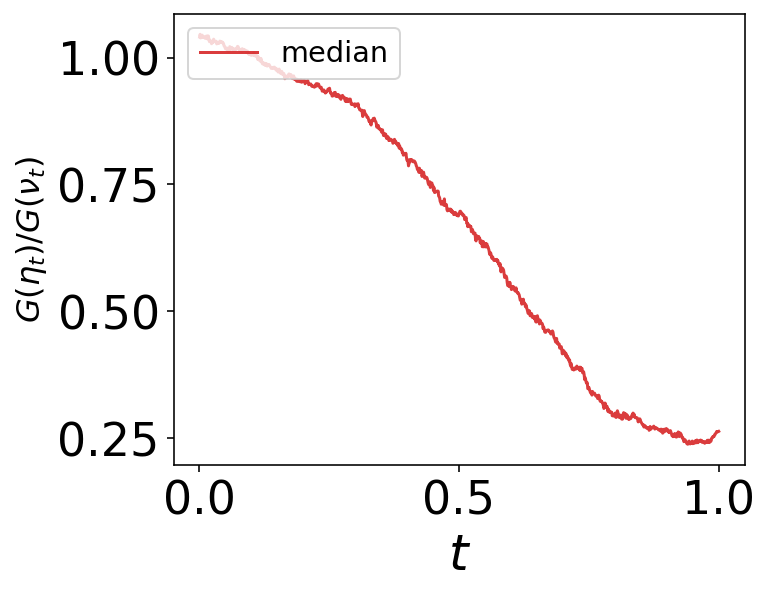

In [22]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

ax.plot(env.timesteps[1:], np.median(ratio_IB_base,axis=1),  'tab:red', alpha = 0.9, label = 'median')
#ax.fill_between(env.timesteps[1:].reshape(-1,),qtl_IB_base[0],qtl_IB_base[-1],alpha=0.25, color='tab:orange')
ax.legend(loc = 'upper left')
ax.set_ylabel(r'$G\left(\eta_t\right) / G\left(\nu_t\right)$', fontsize = 16)
ax.set_xlabel(r'$t$', fontsize = 16)
resolution_value = 100
plt.tight_layout()

ax.set_xlabel(r'$t$', fontsize = font1)
ax.tick_params(axis='both', which='major', labelsize=font2)

#plt.ylim(-5,5)

#plt.savefig('figures/externalisation_plot.pdf', format="pdf", dpi=resolution_value)
plt.show()

In [25]:
sim_collections_stressed = dict(zip(param_list_name, [[] for param in param_list_name]))
inf_trader_collections_stressed = dict(zip(param_list_name, [[] for param in param_list_name]))
broker_collections_stressed = dict(zip(param_list_name, [[] for param in param_list_name]))

In [26]:
for param_name in param_list_name:
    
    for err_name, param_val in param_list_val[param_name].items():
        
        param = param_list_base.copy()
        param[param_name] = param_val

        params_env_stressed = {'b': 1e-03, 'alpha0': 0, 'kappa_alpha': param['kappa_alpha'], 'sigma_alpha': param['sigma_alpha'], 
                           'S0': 100., 'sigma_s': 1, 'corr': 0., 'T': 1., 'Nt': 1_000}

        env_stressed = utils_old.environment(**params_env_stressed)
        
        np.random.seed(seed_alpha)
        alpha_stressed = env_stressed.simulate_alpha(nsims = nsims)

        params_inf_stressed = {'env': env, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                          'sigma_B' : param['sigma_B'], 'mu_B' : 0., 'theta_B' : param['theta_B'], 'sigma_0' : 0, 'c_importance' : 1}

        inf_trader_stressed =  utils_old.informed(**params_inf_stressed)

        inf_trader_collections_stressed[param_name].append(inf_trader_stressed)

        params_broker_stressed = {'env': env_stressed, 'inf': inf_trader_stressed, 'uninf': uninf_trader,
                         'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-01, 'beta1': 1e-03, 'rho0': 1e-03, 'rho1': 1e-05, 
                         'sigma_B': inf_trader_stressed.sigma_B, 'mu_B': inf_trader_stressed.mu_B, 'theta_B': inf_trader_stressed.theta_B, 
                         'sigma_0': 0, 'scale_ivp': scale_ivp}

        broker_stressed = utils_old.broker(**params_broker_stressed)

        broker_collections_stressed[param_name].append(broker)

        model = simulations_old.simulation(env_stressed, inf_trader_stressed, uninf_trader, broker_stressed, 
                                       W, alpha_stressed, nu_U, 
                                       strategy = strategy, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)

        sim_collections_stressed[param_name].append(model)

In [27]:
param_label = {'kappa_alpha': r'$\kappa^\alpha$',
               'sigma_alpha': r'$\sigma^\alpha$',
               'theta_B': r'$\theta^B$',
               'sigma_B': r'$\sigma^B$'}

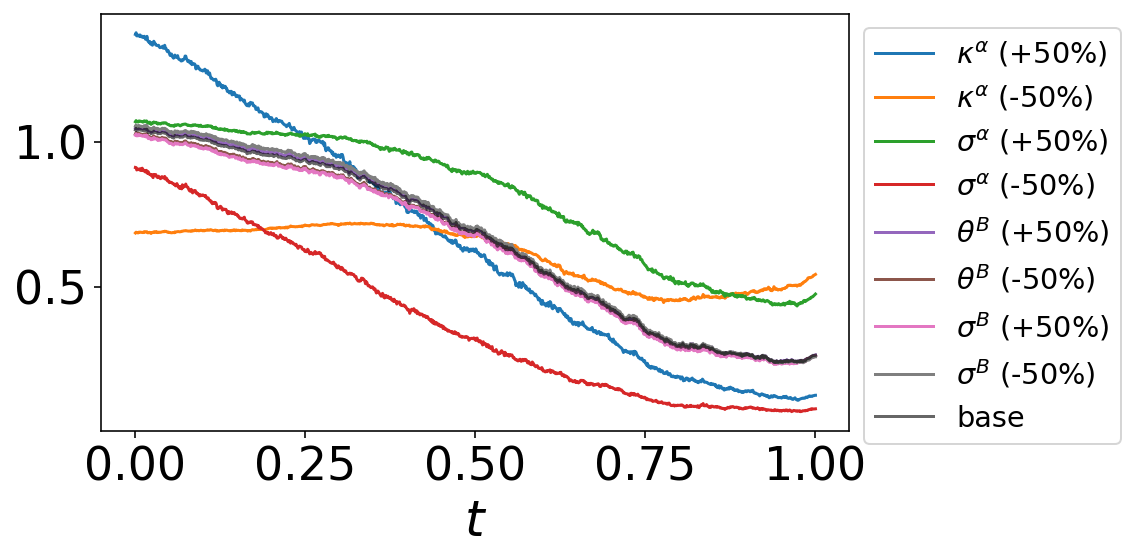

In [28]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

for param_name in param_list_name:
    
    for j, (err_name, param_val) in enumerate(param_list_val[param_name].items()):
        
        nu_B = sim_collections_stressed[param_name][j].nu_B
        nu_I = sim_collections_stressed[param_name][j].nu_I
        ratio_IB = auxF(nu_I[1:, :])/auxF(nu_B[1:, :])
        ratio_IB_median = np.median(ratio_IB,axis=1)
        
        ax.plot(env.timesteps[1:], ratio_IB_median, label=param_label[param_name] + f' ({err_name})')
        
ax.plot(env.timesteps[1:], ratio_IB_base_median, label='base', color='black', alpha=0.6)

ax.legend(bbox_to_anchor=(1,1), loc="upper left")

ax.set_xlabel(r'$t$', fontsize = font1)
ax.tick_params(axis='both', which='major', labelsize=font2)

plt.tight_layout()
plt.show()

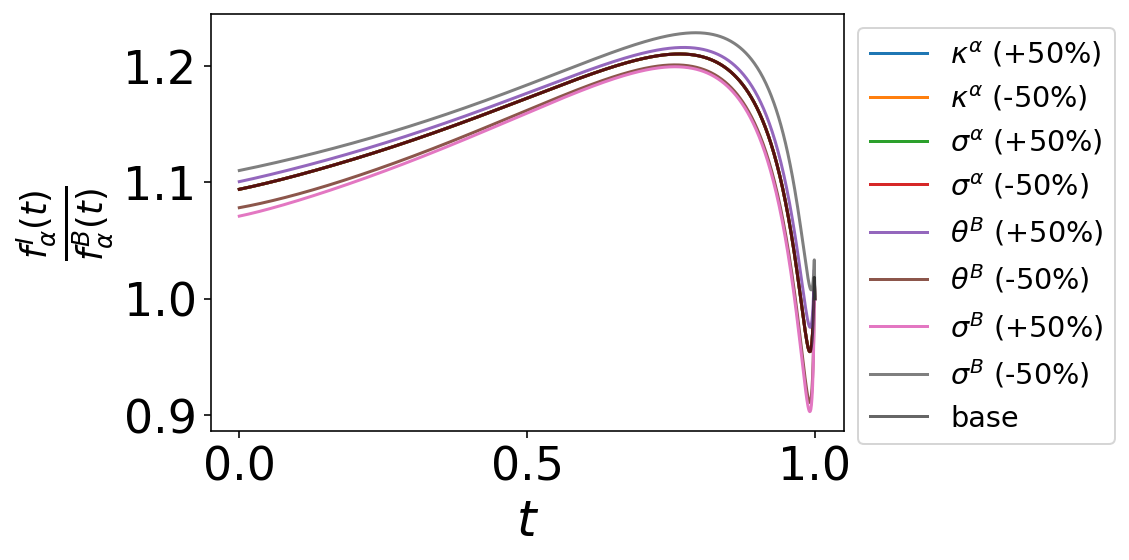

In [27]:
coef_alpha_B_base= broker.coef_speed_B[:, 0, 2]
z_base = inf_trader.z
coef_alpha_I_base = z_base[1] / 2 / inf_trader.k

ratio_coef_alpha_base = auxF(coef_alpha_I_base)/auxF(coef_alpha_B_base)

fig, ax = plt.subplots(1,1,figsize=(8,4))

for param_name in param_list_name:
    
    for j, (err_name, param_val) in enumerate(param_list_val[param_name].items()):
        
        coef_alpha_B = broker_collections_stressed[param_name][j].coef_speed_B[:, 0, 2]
        z = inf_trader_collections_stressed[param_name][j].z
        coef_alpha_I = z[1] / 2 / inf_trader_collections_stressed[param_name][j].k
        
        ratio_coef_alpha = auxF(coef_alpha_I)/auxF(coef_alpha_B)
        
        ax.plot(env.timesteps, ratio_coef_alpha, label=param_label[param_name] + f' ({err_name})')
        
ax.plot(env.timesteps, ratio_coef_alpha_base, label='base', color='black', alpha=0.6)

ax.legend(bbox_to_anchor=(1,1), loc="upper left")

ax.set_xlabel(r'$t$', fontsize = font1)
ax.tick_params(axis='both', which='major', labelsize=font2)
ax.set_ylabel(r'$\frac{f_\alpha^I(t)}{f_\alpha^B(t)}$', fontsize = font1)

plt.tight_layout()
plt.show()

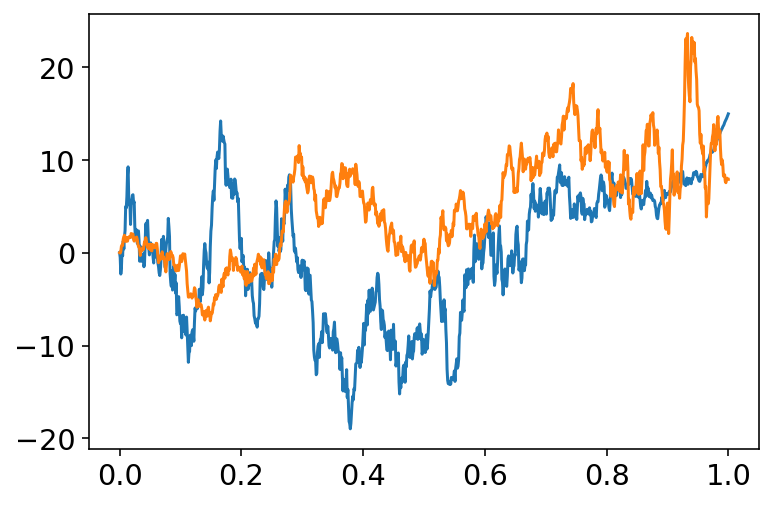

In [64]:
plt.plot(env.timesteps, sim_collections['kappa_alpha'][1].nu_I[:,1])
plt.plot(env.timesteps, sim_collections['kappa_alpha'][1].nu_B[:,1])

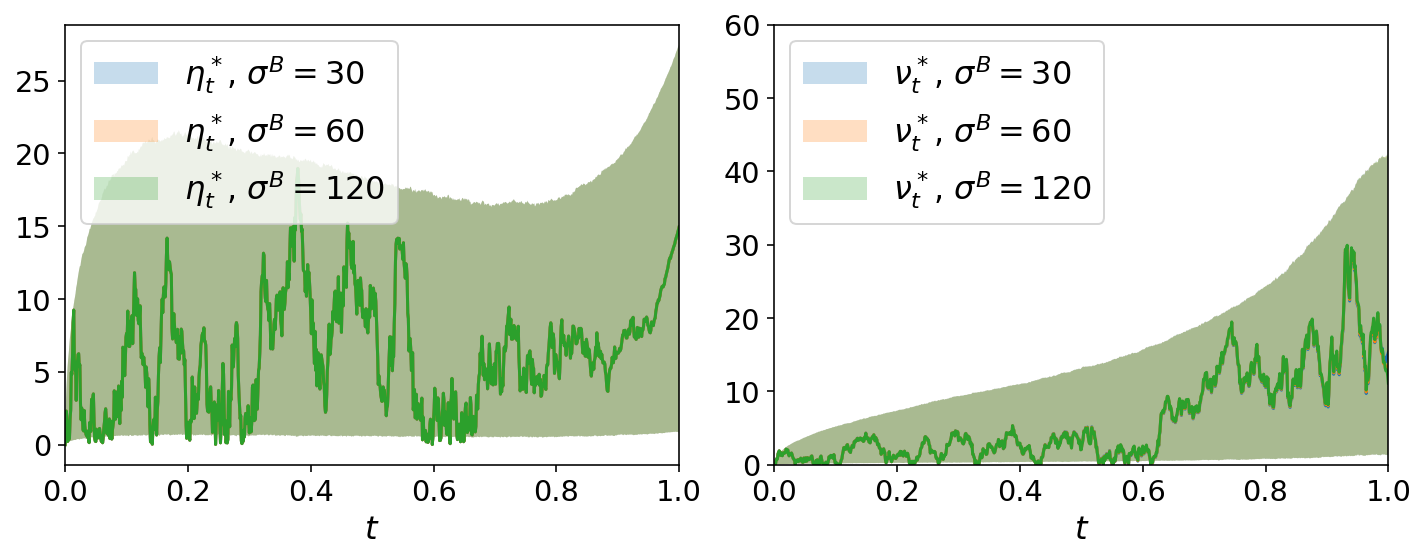

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
t = env.timesteps

for i, sigma_B in enumerate(sigma_B_list):
    qtl_nu_I = np.quantile(np.abs(sim_collections[i].nu_I),[0.05,0.5,0.95], axis=1)
    qtl_nu_B = np.quantile(np.abs(sim_collections[i].nu_B),[0.05,0.5,0.95], axis=1)
    
    ax[0].fill_between(t,qtl_nu_I[0],qtl_nu_I[-1],alpha=0.25, label=r'$\eta_t^*$, $\sigma^B=$' + f'{sigma_B}')
    ax[1].fill_between(t,qtl_nu_B[0],qtl_nu_B[-1],alpha=0.25, label=r'$\nu_t^*$, $\sigma^B=$' + f'{sigma_B}')
    ax[0].plot(t, np.abs(sim_collections[i].nu_I[:,1]), markevery=100)
    ax[1].plot(t, np.abs(sim_collections[i].nu_B[:,1]), markevery=100)
    ax[0].set_xlabel(r'$t$',fontsize=16)
    ax[0].legend(fontsize=16,loc='upper left')
    
    ax[1].set_xlabel(r'$t$',fontsize=16)
    ax[1].legend(fontsize=16,loc='upper left')
    
    ax[0].set_xlim(0.,1)
    ax[1].set_xlim(0.,1)

    
ax[1].set_ylim(0., 60)
plt.tight_layout()
plt.show()

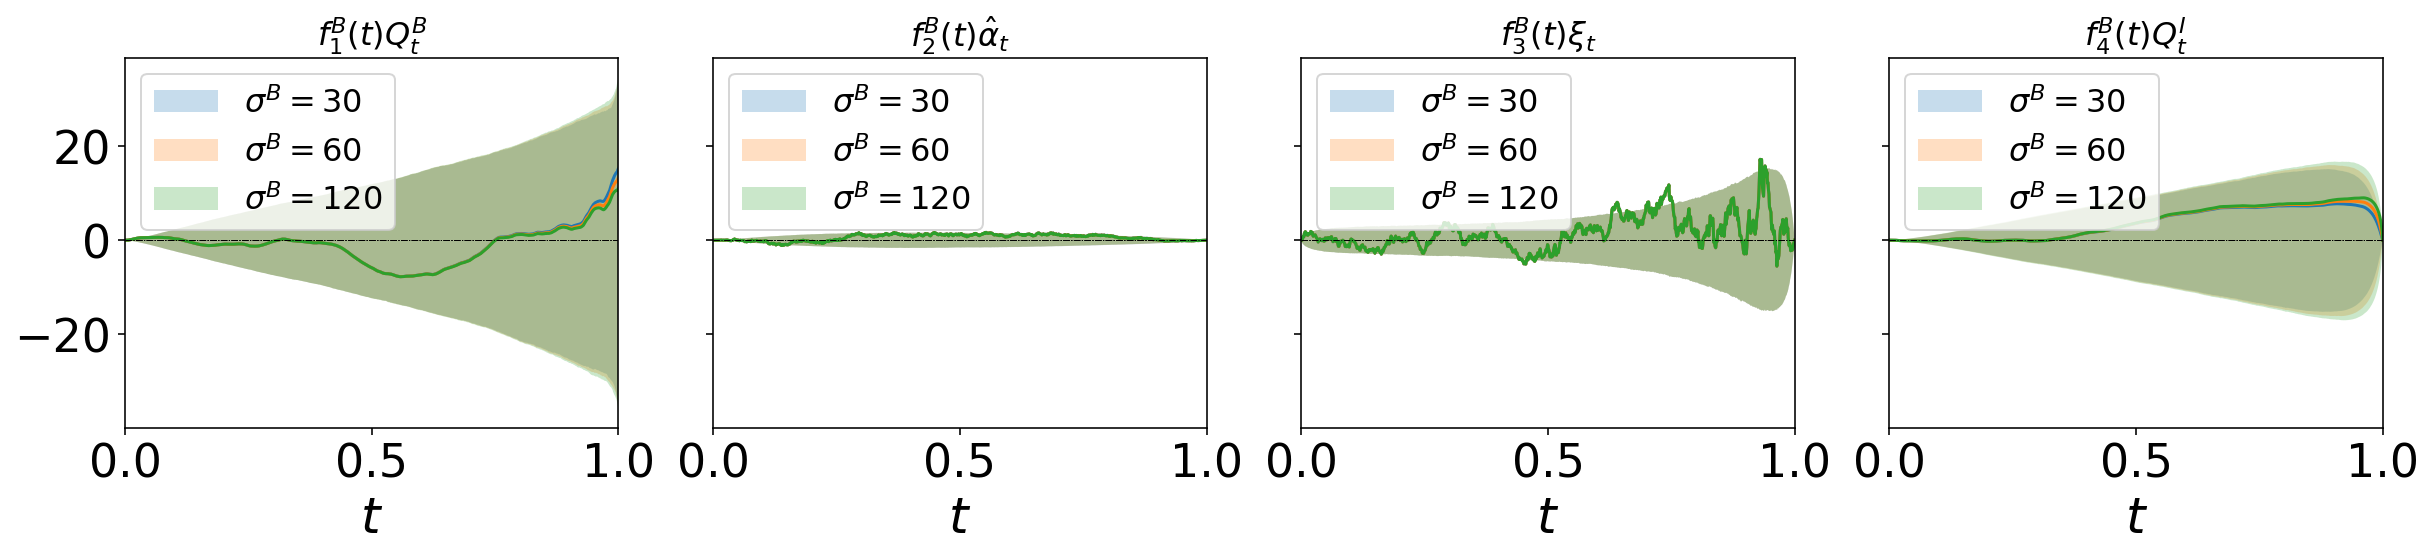

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(17,4), sharey='row')

for i, sigma_B in enumerate(sigma_B_list):

    state_B = {1:(sim_collections[i].Q_B, r'$f_1^B(t)$', r'$Q_t^B$', 'tab:blue'), 
               2:(sim_collections[i].alpha_hat, r'$f_2^B(t)$', alpha_est_name[strategy_type], 'tab:purple'),
               3:(sim_collections[i].nu_U, r'$f_3^B(t)$', r'$\xi_t$', 'tab:gray'),
               4:(sim_collections[i].Q_I, r'$f_4^B(t)$', r'$Q_t^I$', 'tab:orange')}

    for j, (var_name_1, var_label_1, var_label_2, colour) in state_B.items():

        coef_var_1 = broker_collections[i].coef_speed_B[:, 0, j]

        nu_B_var_1 = ((coef_var_1.reshape((-1,1)))@np.ones(shape=(1,nsims)))*var_name_1

        nu_B_var_qtl = np.quantile(nu_B_var_1,[0.05,0.5,0.95], axis=1)

        ax[j-1].fill_between(t,nu_B_var_qtl[0],nu_B_var_qtl[-1],alpha=0.25, label=r'$\sigma^B=$' + f'{sigma_B}')
        ax[j-1].plot(t, nu_B_var_1[:,1])
        ax[j-1].set_xlabel(r'$t$',fontsize=16)
        ax[j-1].set_title(var_label_1 + var_label_2,fontsize=16)
        ax[j-1].legend(fontsize=16,loc='upper left')
        ax[j-1].set_xlim(0,1)
        ax[j-1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
    
ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)
ax[3].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)
ax[3].tick_params(axis='both', which='major', labelsize=font2)
    
plt.tight_layout()
#plt.savefig(f'figures/nuB coef {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

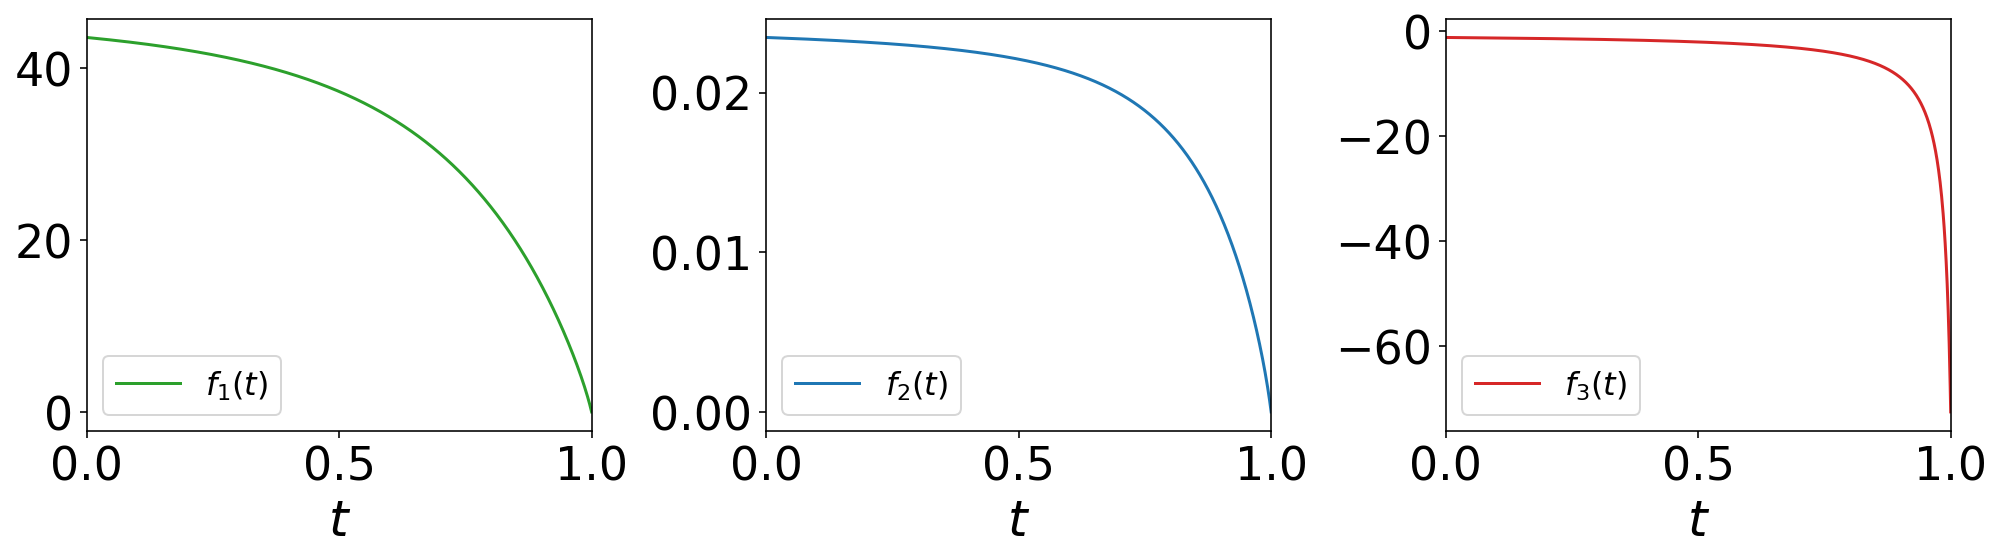

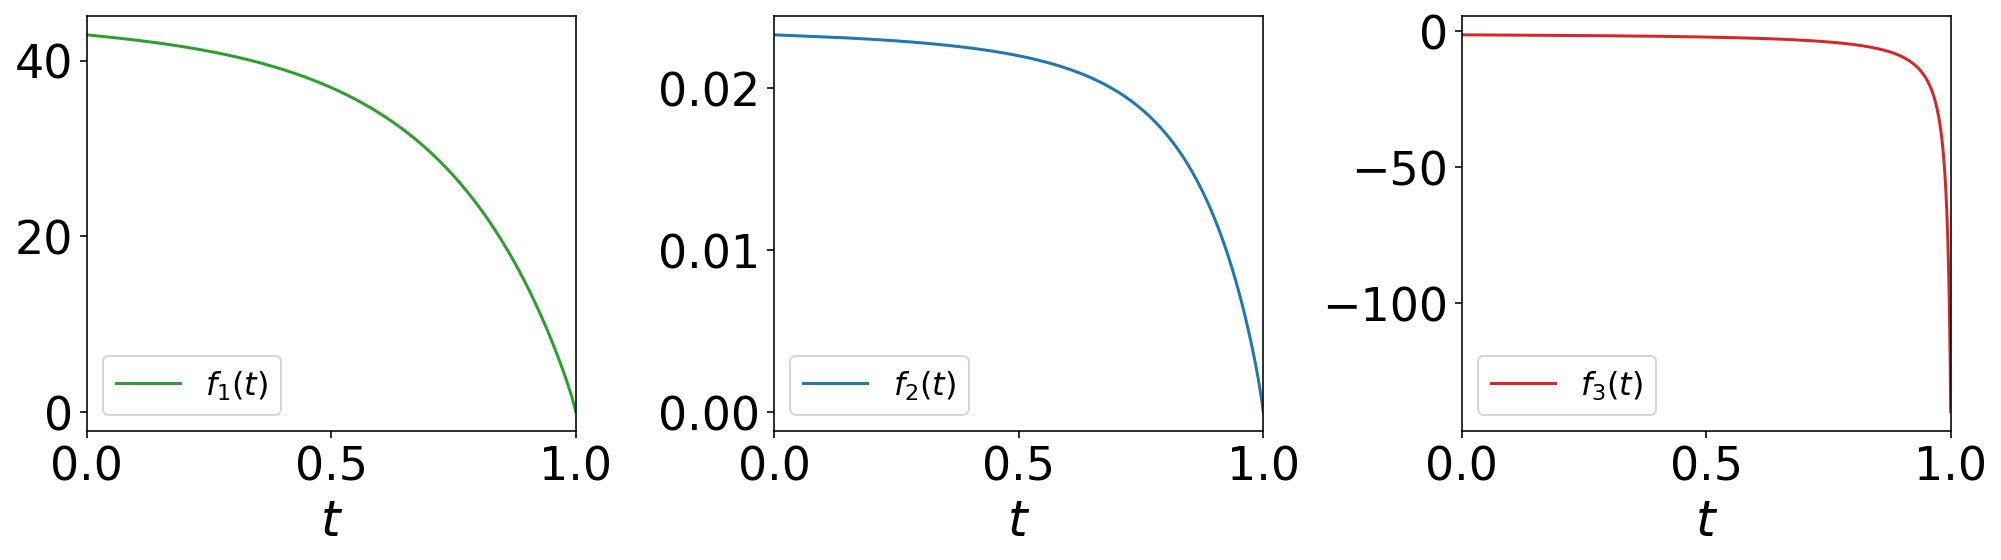

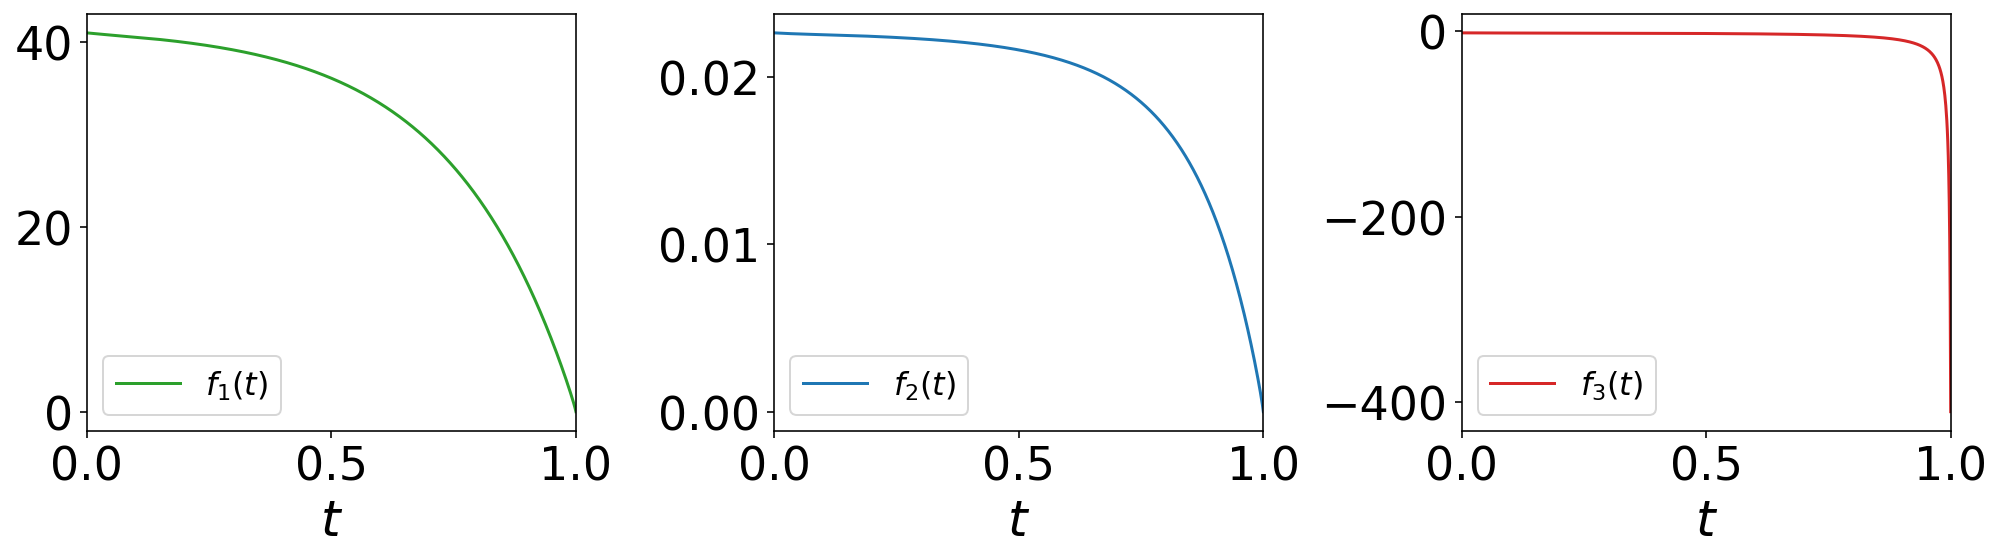

In [37]:
for inf_trader in inf_trader_misp_collections:

    z = inf_trader.z
    f3 = z[9] / inf_trader.k
    f0 = z[0] / 2 / inf_trader.k
    f2 = inf_trader.c_importance * z[2] / 2 / inf_trader.k
    f1 = z[1] / 2 / inf_trader.k

    fig, ax = plt.subplots(1, 3, figsize=(14,4))

    ax[0].plot(t, f1, label = r'$f_1(t)$', color='tab:green')
    ax[1].plot(t, f2, label = r'$f_2(t)$', color='tab:blue')
    ax[2].plot(t, f3, label = r'$f_3(t)$', color='tab:red')

    ax[0].legend(fontsize=16,loc='lower left')
    ax[1].legend(fontsize=16,loc='lower left')
    ax[2].legend(fontsize=16,loc='lower left')

    ax[0].set_xlabel(r'$t$', fontsize = font1)
    ax[1].set_xlabel(r'$t$', fontsize = font1)
    ax[2].set_xlabel(r'$t$', fontsize = font1)

    ax[0].tick_params(axis='both', which='major', labelsize=font2)
    ax[1].tick_params(axis='both', which='major', labelsize=font2)
    ax[2].tick_params(axis='both', which='major', labelsize=font2)

    ax[0].set_xlim(0,1)
    ax[1].set_xlim(0,1)
    ax[2].set_xlim(0,1)

    plt.tight_layout()
    plt.show()

## 4b. Mispecified $\theta^B$

In [12]:
sim_collections_theta_B = []
inf_trader_collections_theta_B = []
inf_trader_misp_collections_theta_B = []
broker_collections_theta_B = []

In [13]:
for theta_B in theta_B_list:

    scale_ivp = 100000 # change this to change the scale in solving ivp for V_B

    params_inf = {'env': env, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                      'sigma_B' : 60., 'mu_B' : 0., 'theta_B' : 10., 'sigma_0' : 0, 'c_importance' : 1}
    
    params_inf_misp = {'env': env, 'Q0' : 0., 'k' : 2e-03, 'beta0' : 1e-01, 'beta1' : 1e-03, 'rho0' : 1e-03, 'rho1' : 1e-05,
                      'sigma_B' : 60., 'mu_B' : 0., 'theta_B' : theta_B, 'sigma_0' : 0, 'c_importance' : 1}

    inf_trader =  utils.informed(**params_inf)
    
    inf_trader_misp =  utils.informed(**params_inf_misp)
    
    inf_trader_collections_theta_B.append(inf_trader)
    
    inf_trader_misp_collections_theta_B.append(inf_trader_misp)

    params_broker = {'env': env, 'inf': inf_trader_misp, 'uninf': uninf_trader,
                     'Q0': 0, 'k': 2.1e-03, 'beta0': 1e-01, 'beta1': 1e-03, 'rho0': 1e-03, 'rho1': 1e-05, 
                     'sigma_B': inf_trader_misp.sigma_B, 'mu_B': inf_trader_misp.mu_B, 'theta_B': inf_trader_misp.theta_B, 
                     'sigma_0': 0, 'scale_ivp': scale_ivp}

    broker = utils.broker(**params_broker)
    
    broker_collections_theta_B.append(broker)

    model = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                                   W, alpha, nu_U, 
                                   strategy = strategy_type, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)
    
    sim_collections_theta_B.append(model)

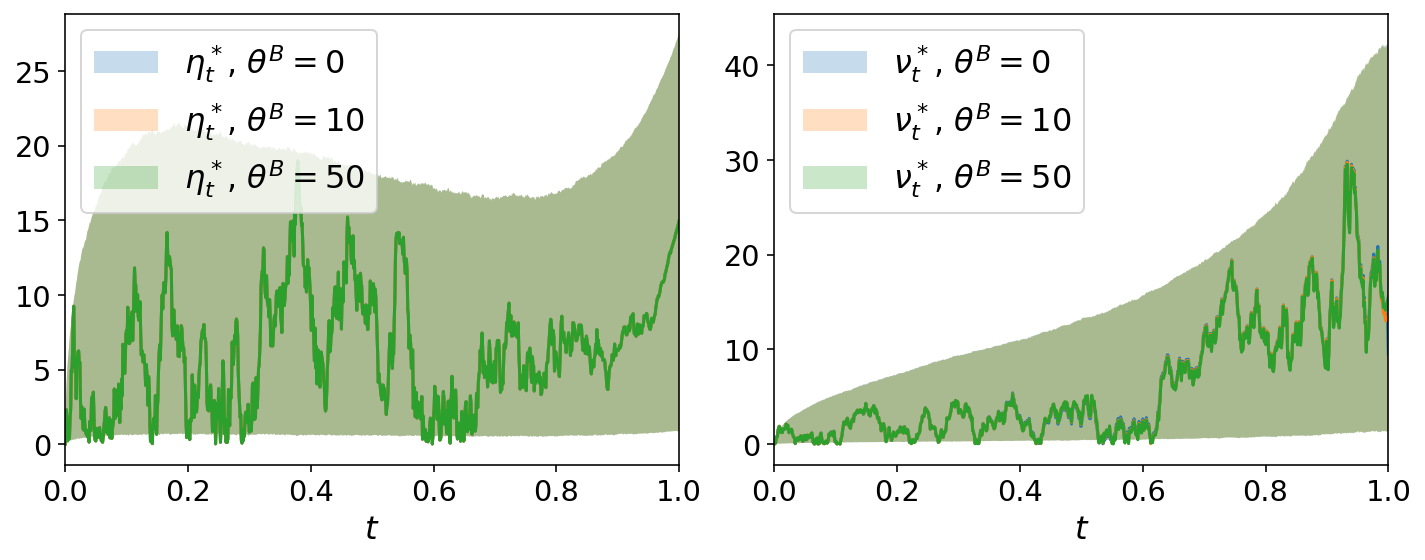

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
t = env.timesteps

for i, theta_B in enumerate(theta_B_list):
    qtl_nu_I = np.quantile(np.abs(sim_collections_theta_B[i].nu_I),[0.05,0.5,0.95], axis=1)
    qtl_nu_B = np.quantile(np.abs(sim_collections_theta_B[i].nu_B),[0.05,0.5,0.95], axis=1)
    
    ax[0].fill_between(t,qtl_nu_I[0],qtl_nu_I[-1],alpha=0.25, label=r'$\eta_t^*$, $\theta^B=$' + f'{theta_B}')
    ax[1].fill_between(t,qtl_nu_B[0],qtl_nu_B[-1],alpha=0.25, label=r'$\nu_t^*$, $\theta^B=$' + f'{theta_B}')
    ax[0].plot(t, np.abs(sim_collections_theta_B[i].nu_I[:,1]), markevery=100)
    ax[1].plot(t, np.abs(sim_collections_theta_B[i].nu_B[:,1]), markevery=100)
    ax[0].set_xlabel(r'$t$',fontsize=16)
    ax[0].legend(fontsize=16,loc='upper left')
    
    ax[1].set_xlabel(r'$t$',fontsize=16)
    ax[1].legend(fontsize=16,loc='upper left')
    
    ax[0].set_xlim(0.,1)
    ax[1].set_xlim(0.,1)

    
#ax[1].set_ylim(0., 60)
plt.tight_layout()
plt.show()

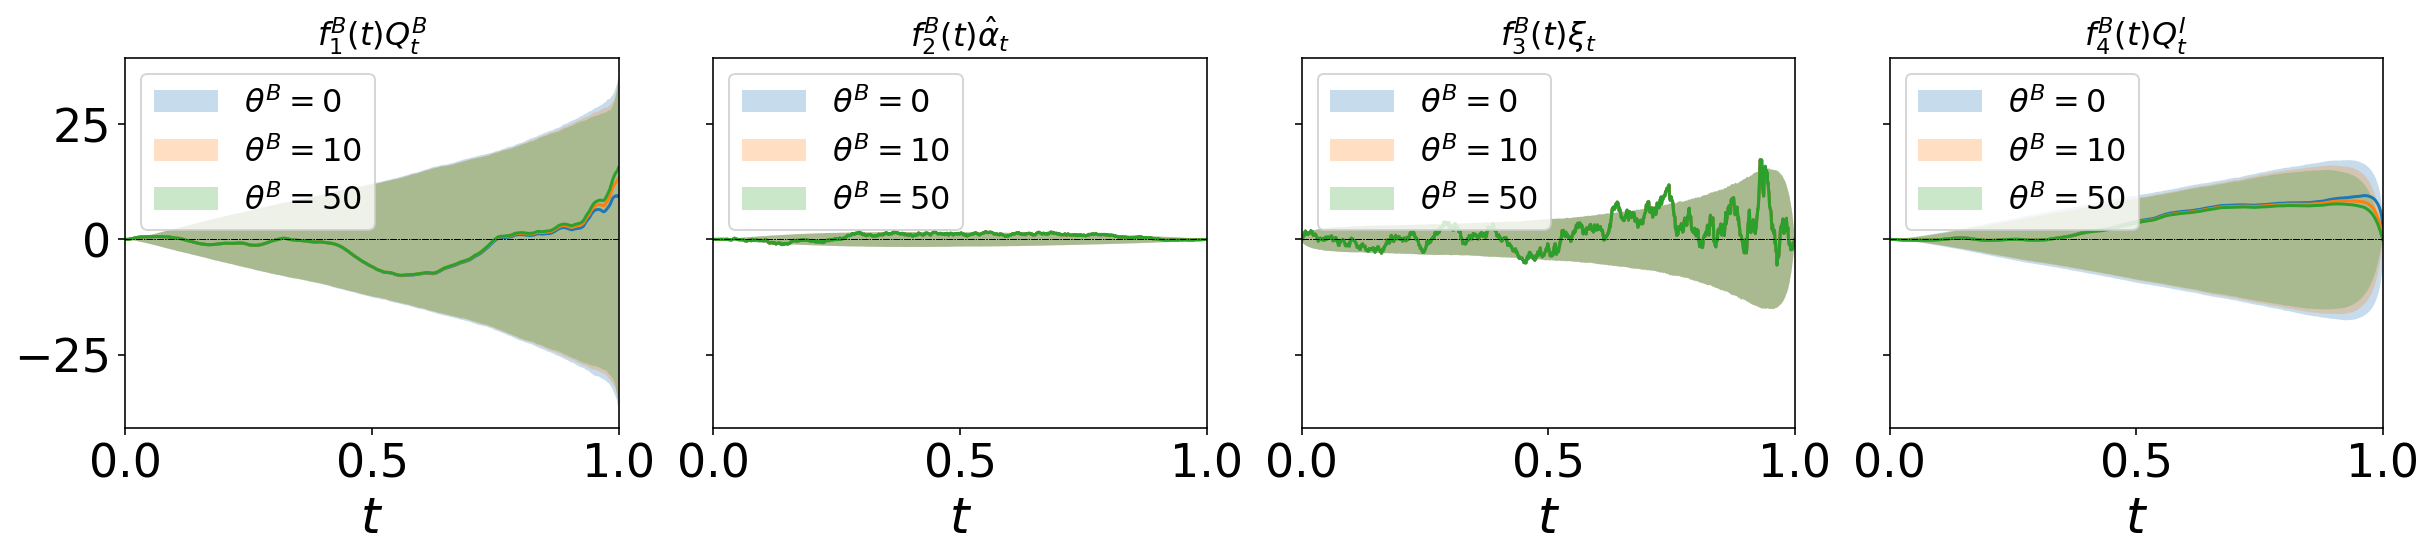

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(17,4), sharey='row')

for i, theta_B in enumerate(theta_B_list):

    state_B = {1:(sim_collections_theta_B[i].Q_B, r'$f_1^B(t)$', r'$Q_t^B$', 'tab:blue'), 
               2:(sim_collections_theta_B[i].alpha_hat, r'$f_2^B(t)$', alpha_est_name[strategy_type], 'tab:purple'),
               3:(sim_collections_theta_B[i].nu_U, r'$f_3^B(t)$', r'$\xi_t$', 'tab:gray'),
               4:(sim_collections_theta_B[i].Q_I, r'$f_4^B(t)$', r'$Q_t^I$', 'tab:orange')}

    for j, (var_name_1, var_label_1, var_label_2, colour) in state_B.items():

        coef_var_1 = broker_collections_theta_B[i].coef_speed_B[:, 0, j]

        nu_B_var_1 = ((coef_var_1.reshape((-1,1)))@np.ones(shape=(1,nsims)))*var_name_1

        nu_B_var_qtl = np.quantile(nu_B_var_1,[0.05,0.5,0.95], axis=1)

        ax[j-1].fill_between(t,nu_B_var_qtl[0],nu_B_var_qtl[-1],alpha=0.25, label=r'$\theta^B=$' + f'{theta_B}')
        ax[j-1].plot(t, nu_B_var_1[:,1])
        ax[j-1].set_xlabel(r'$t$',fontsize=16)
        ax[j-1].set_title(var_label_1 + var_label_2,fontsize=16)
        ax[j-1].legend(fontsize=16,loc='upper left')
        ax[j-1].set_xlim(0,1)
        ax[j-1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
    
ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)
ax[3].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)
ax[3].tick_params(axis='both', which='major', labelsize=font2)
    
plt.tight_layout()
#plt.savefig(f'figures/nuB coef {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

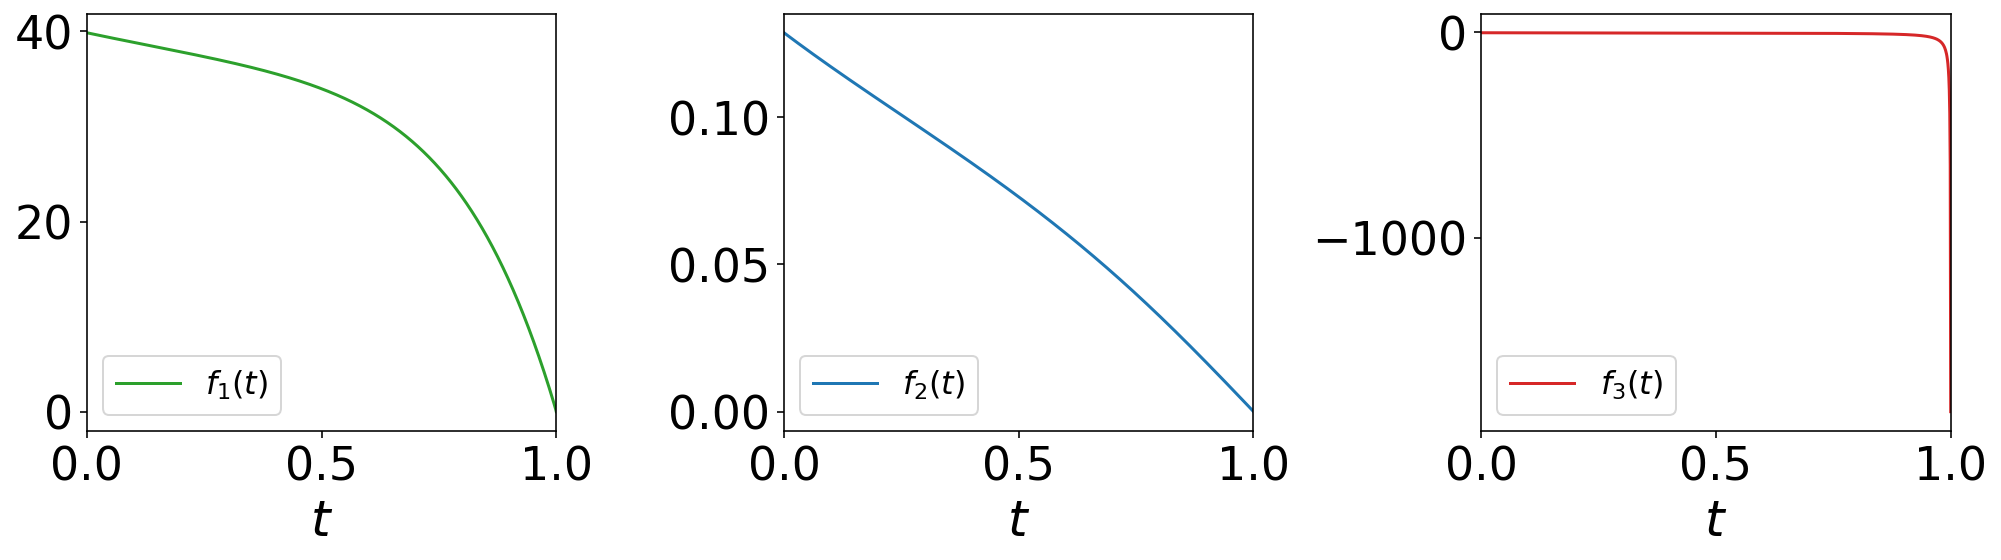

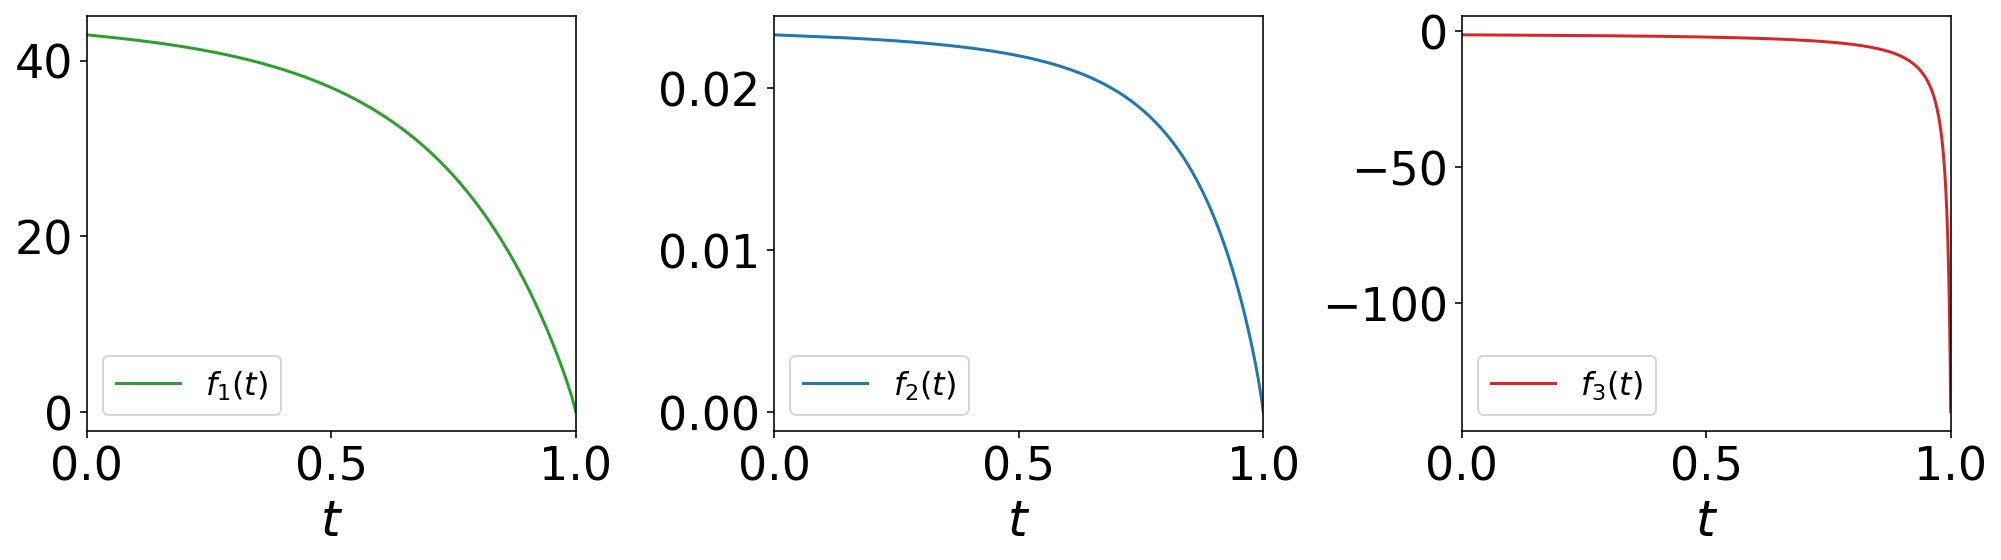

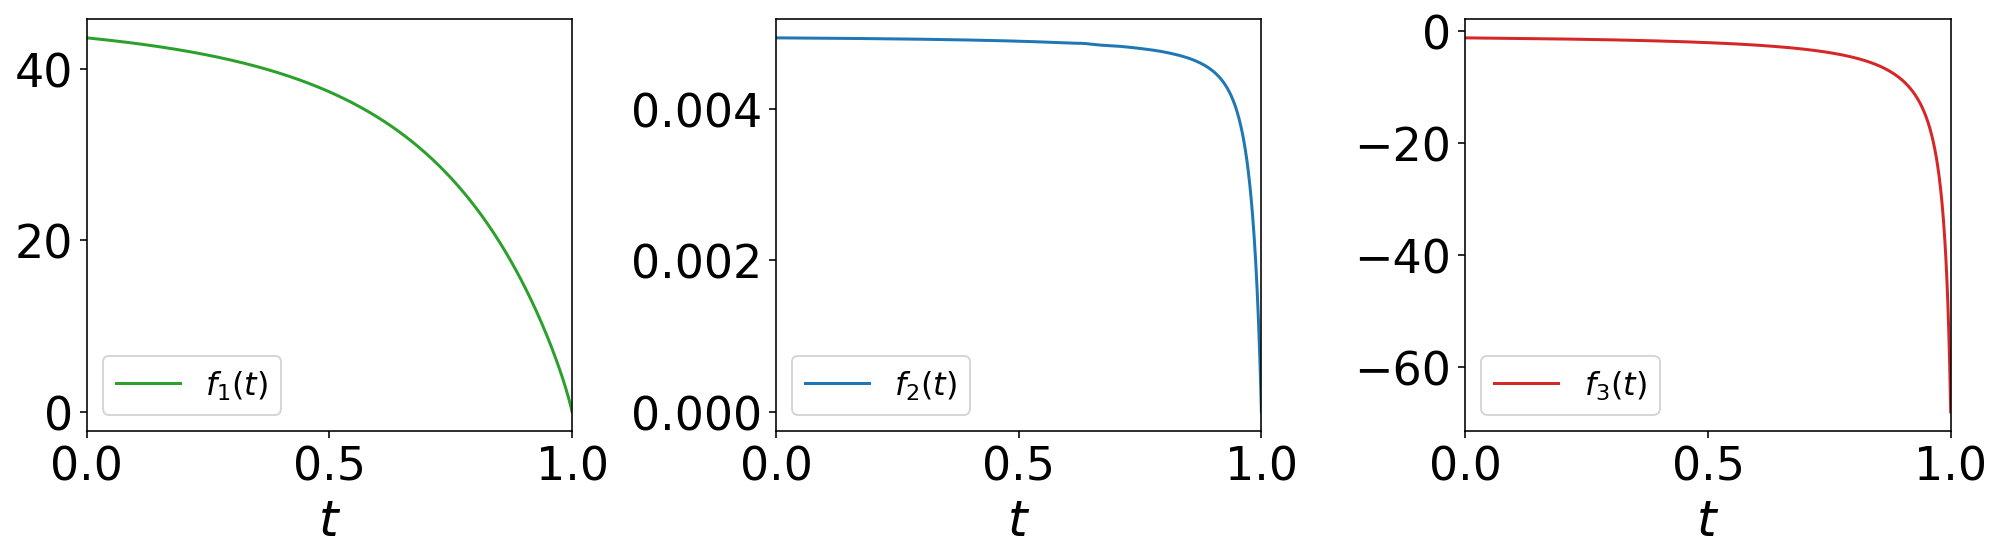

In [15]:
for inf_trader in inf_trader_misp_collections_theta_B:

    z = inf_trader.z
    f3 = z[9] / inf_trader.k
    f0 = z[0] / 2 / inf_trader.k
    f2 = inf_trader.c_importance * z[2] / 2 / inf_trader.k
    f1 = z[1] / 2 / inf_trader.k

    fig, ax = plt.subplots(1, 3, figsize=(14,4))

    ax[0].plot(t, f1, label = r'$f_1(t)$', color='tab:green')
    ax[1].plot(t, f2, label = r'$f_2(t)$', color='tab:blue')
    ax[2].plot(t, f3, label = r'$f_3(t)$', color='tab:red')

    ax[0].legend(fontsize=16,loc='lower left')
    ax[1].legend(fontsize=16,loc='lower left')
    ax[2].legend(fontsize=16,loc='lower left')

    ax[0].set_xlabel(r'$t$', fontsize = font1)
    ax[1].set_xlabel(r'$t$', fontsize = font1)
    ax[2].set_xlabel(r'$t$', fontsize = font1)

    ax[0].tick_params(axis='both', which='major', labelsize=font2)
    ax[1].tick_params(axis='both', which='major', labelsize=font2)
    ax[2].tick_params(axis='both', which='major', labelsize=font2)

    ax[0].set_xlim(0,1)
    ax[1].set_xlim(0,1)
    ax[2].set_xlim(0,1)

    plt.tight_layout()
    plt.show()

In [ ]:
# plot the components of trader's speed

t = env.timesteps

fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey='row')

z = inf_trader.z
f3 = z[9] / inf_trader.k
f2 = z[2] / 2 / inf_trader.k
f1 = z[1] / 2 / inf_trader.k
f0 = z[0] / 2 / inf_trader.k

nu_I_0 = f0
nu_I_alpha = ((f1.reshape((-1,1)))@np.ones(shape=(1,nsims)))*model.alpha
nu_I_nu_B_hat = ((f2.reshape((-1,1)))@np.ones(shape=(1,nsims)))*model.nu_B_hat
nu_I_Q_I = ((f3.reshape((-1,1)))@np.ones(shape=(1,nsims)))*model.Q_I

nu_I_alpha_qtl = np.quantile(nu_I_alpha,[0.05,0.5,0.95], axis=1)
nu_I_nu_B_hat_qtl = np.quantile(nu_I_nu_B_hat,[0.05,0.5,0.95], axis=1)
nu_I_Q_I_qtl = np.quantile(nu_I_Q_I,[0.05,0.5,0.95], axis=1)

nu_B_hat_qtl = np.quantile(model.nu_B_hat,[0.05,0.5,0.95], axis=1)
alpha_qtl = np.quantile(model.alpha,[0.05,0.5,0.95], axis=1)
Q_I_qtl = np.quantile(model.Q_I,[0.05,0.5,0.95], axis=1)

ax[0].fill_between(t,nu_I_alpha_qtl[0],nu_I_alpha_qtl[-1], alpha=0.25, label=r'$f_1(t)\, \alpha_t$', color='tab:green')
ax[0].plot(t, nu_I_alpha[:,1], markevery=100, color='tab:green')
ax[0].set_xlabel(r'$t$',fontsize=16)
ax[0].legend(fontsize=16,loc='upper left')
ax[0].set_xlim(0,1)
ax[0].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
#ax[1,1].set_ylim(y_lim_1)

ax[1].fill_between(t,nu_I_nu_B_hat_qtl[0],nu_I_nu_B_hat_qtl[-1], alpha=0.25, label=r'$f_2(t)\, \hat{\nu}_t$', color='tab:blue')
ax[1].plot(t, nu_I_nu_B_hat[:,1], markevery=100, color='tab:blue')
ax[1].set_xlabel(r'$t$',fontsize=16)
ax[1].legend(fontsize=16,loc='upper left')
ax[1].set_xlim(0,1)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
#ax[1,2].set_ylim(y_lim_1)

ax[2].fill_between(t,nu_I_Q_I_qtl[0],nu_I_Q_I_qtl[-1], alpha=0.25, label=r'$f_3(t)\, Q_t^{I,*}$', color='tab:red')
ax[2].plot(t, nu_I_Q_I[:,1], markevery=100, color='tab:red')
ax[2].set_xlabel(r'$t$',fontsize=16)
ax[2].legend(fontsize=16,loc='upper left')
ax[2].set_xlim(0,1)
ax[2].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
#ax[1,3].set_ylim(y_lim_1)


ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)


plt.tight_layout()
#plt.savefig(f'figures/nuI coef {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

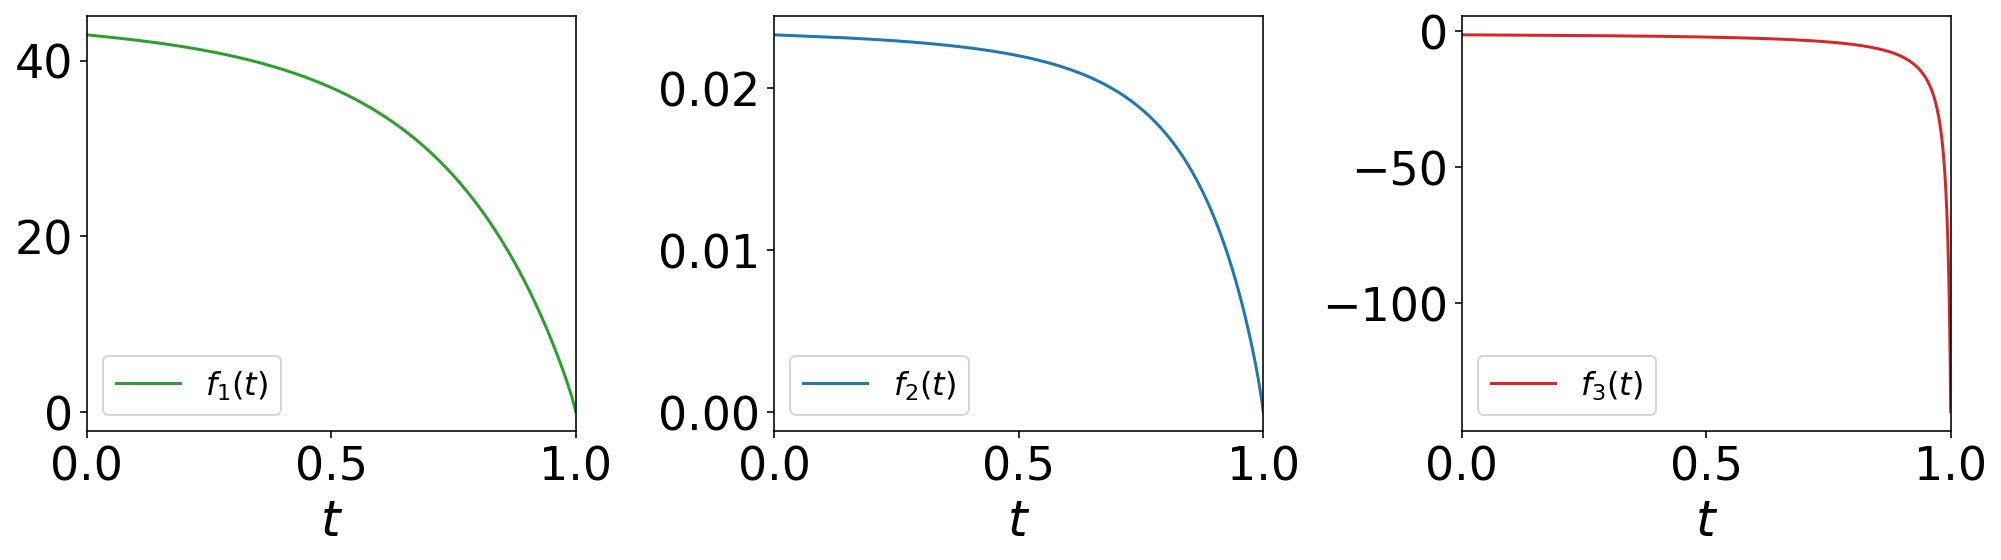

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

ax[0].plot(t, f1, label = r'$f_1(t)$', color='tab:green')
ax[1].plot(t, f2, label = r'$f_2(t)$', color='tab:blue')
ax[2].plot(t, f3, label = r'$f_3(t)$', color='tab:red')

ax[0].legend(fontsize=16,loc='lower left')
ax[1].legend(fontsize=16,loc='lower left')
ax[2].legend(fontsize=16,loc='lower left')

ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)

ax[0].set_xlim(0,1)
ax[1].set_xlim(0,1)
ax[2].set_xlim(0,1)

plt.tight_layout()
plt.show()

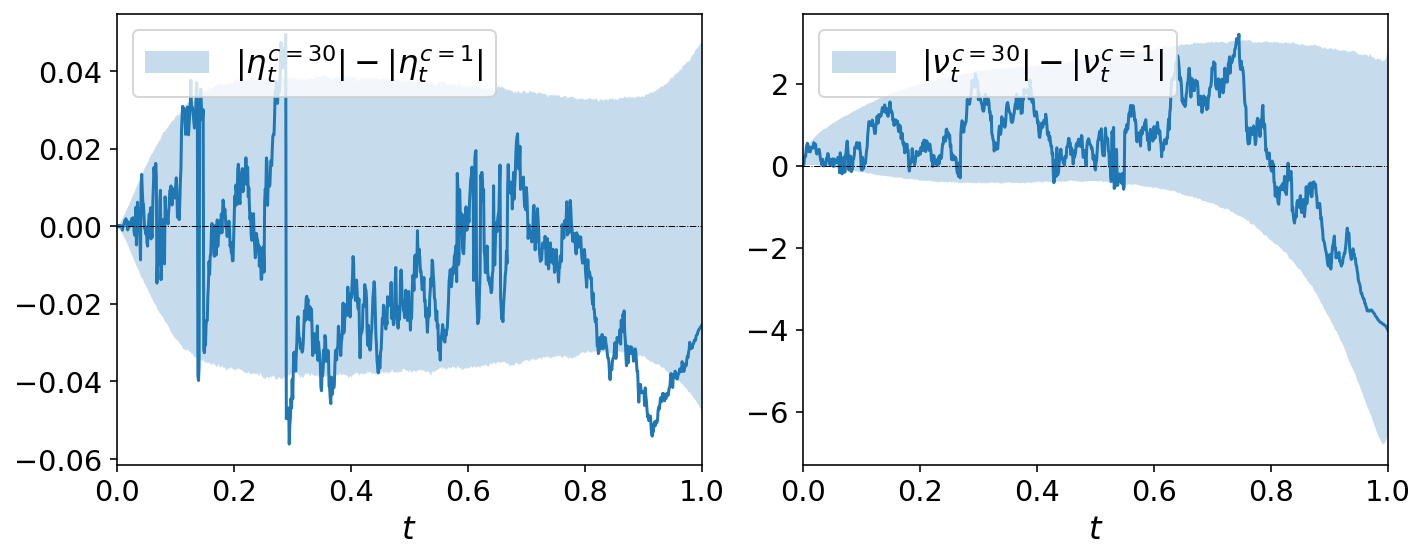

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
t = env.timesteps

nu_I_diff_abs = np.abs(sim_collections[1].nu_I) - np.abs(sim_collections[0].nu_I)
nu_B_diff_abs = np.abs(sim_collections[1].nu_B) - np.abs(sim_collections[0].nu_B)

qtl_nu_I = np.quantile(nu_I_diff_abs,[0.05,0.5,0.95], axis=1)
qtl_nu_B = np.quantile(nu_B_diff_abs,[0.05,0.5,0.95], axis=1)

ax[0].fill_between(t,qtl_nu_I[0],qtl_nu_I[-1],alpha=0.25, label=r'$|\eta_t^{c=30}| - |\eta_t^{c=1}|$')
ax[1].fill_between(t,qtl_nu_B[0],qtl_nu_B[-1],alpha=0.25, label=r'$|\nu_t^{c=30}| - |\nu_t^{c=1}|$')
ax[0].plot(t, nu_I_diff_abs[:,1], markevery=100)
ax[1].plot(t, nu_B_diff_abs[:,1], markevery=100)
ax[0].set_xlabel(r'$t$',fontsize=16)
ax[0].legend(fontsize=16,loc='upper left')

ax[1].set_xlabel(r'$t$',fontsize=16)
ax[1].legend(fontsize=16,loc='upper left')

ax[0].set_xlim(0.,1)
ax[1].set_xlim(0.,1)

ax[0].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)

plt.tight_layout()
plt.show()

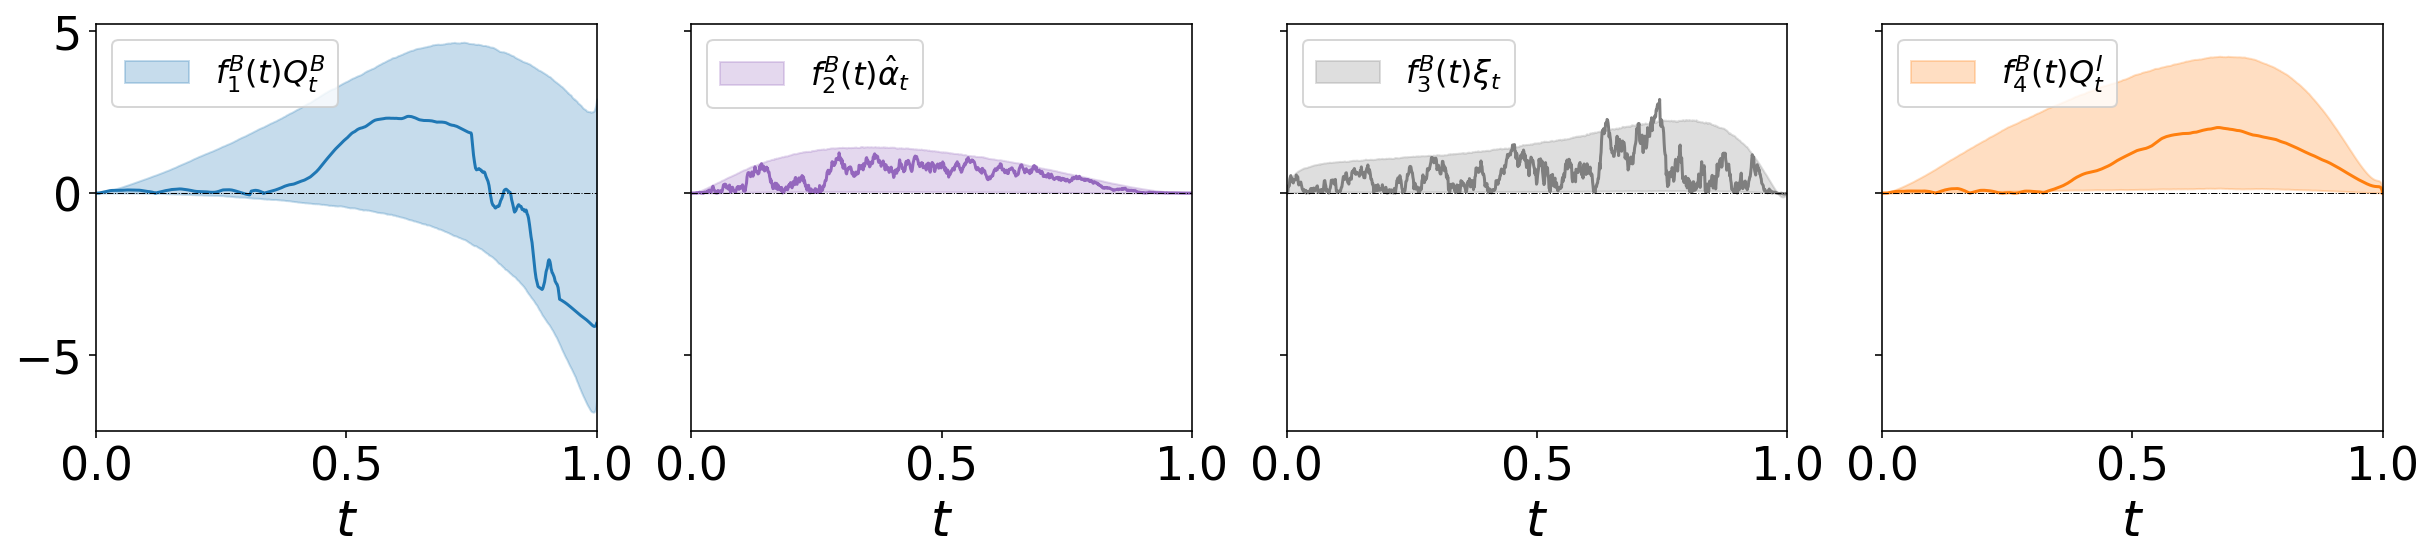

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(17,4), sharey='row')

state_B = {1:(sim_collections[0].Q_B, sim_collections[1].Q_B, r'$f_1^B(t)$', r'$Q_t^B$', 'tab:blue'), 
           2:(sim_collections[0].alpha_hat, sim_collections[1].alpha_hat, r'$f_2^B(t)$', alpha_est_name[strategy_type], 'tab:purple'),
           3:(sim_collections[0].nu_U, sim_collections[1].nu_U, r'$f_3^B(t)$', r'$\xi_t$', 'tab:gray'),
           4:(sim_collections[0].Q_I, sim_collections[1].Q_I, r'$f_4^B(t)$', r'$Q_t^I$', 'tab:orange')}

for j, (var_name_1, var_name_2, var_label_1, var_label_2, colour) in state_B.items():
    
    coef_var_1 = broker_collections[0].coef_speed_B[:, 0, j]
    coef_var_2 = broker_collections[1].coef_speed_B[:, 0, j]
    
    nu_B_var_1 = ((coef_var_1.reshape((-1,1)))@np.ones(shape=(1,nsims)))*var_name_1
    nu_B_var_2 = ((coef_var_2.reshape((-1,1)))@np.ones(shape=(1,nsims)))*var_name_2
    
    nu_B_var_diff_abs = np.abs(nu_B_var_2) - np.abs(nu_B_var_1)
    
    nu_B_var_qtl = np.quantile(nu_B_var_diff_abs,[0.05,0.5,0.95], axis=1)
    
    ax[j-1].fill_between(t,nu_B_var_qtl[0],nu_B_var_qtl[-1],alpha=0.25, label=var_label_1 + var_label_2, color=colour)
    ax[j-1].plot(t, nu_B_var_diff_abs[:,1], color=colour)
    ax[j-1].set_xlabel(r'$t$',fontsize=16)
    ax[j-1].legend(fontsize=16,loc='upper left')
    ax[j-1].set_xlim(0,1)
    ax[j-1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
    
ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)
ax[3].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)
ax[3].tick_params(axis='both', which='major', labelsize=font2)
    
plt.tight_layout()
#plt.savefig(f'figures/nuB coef {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

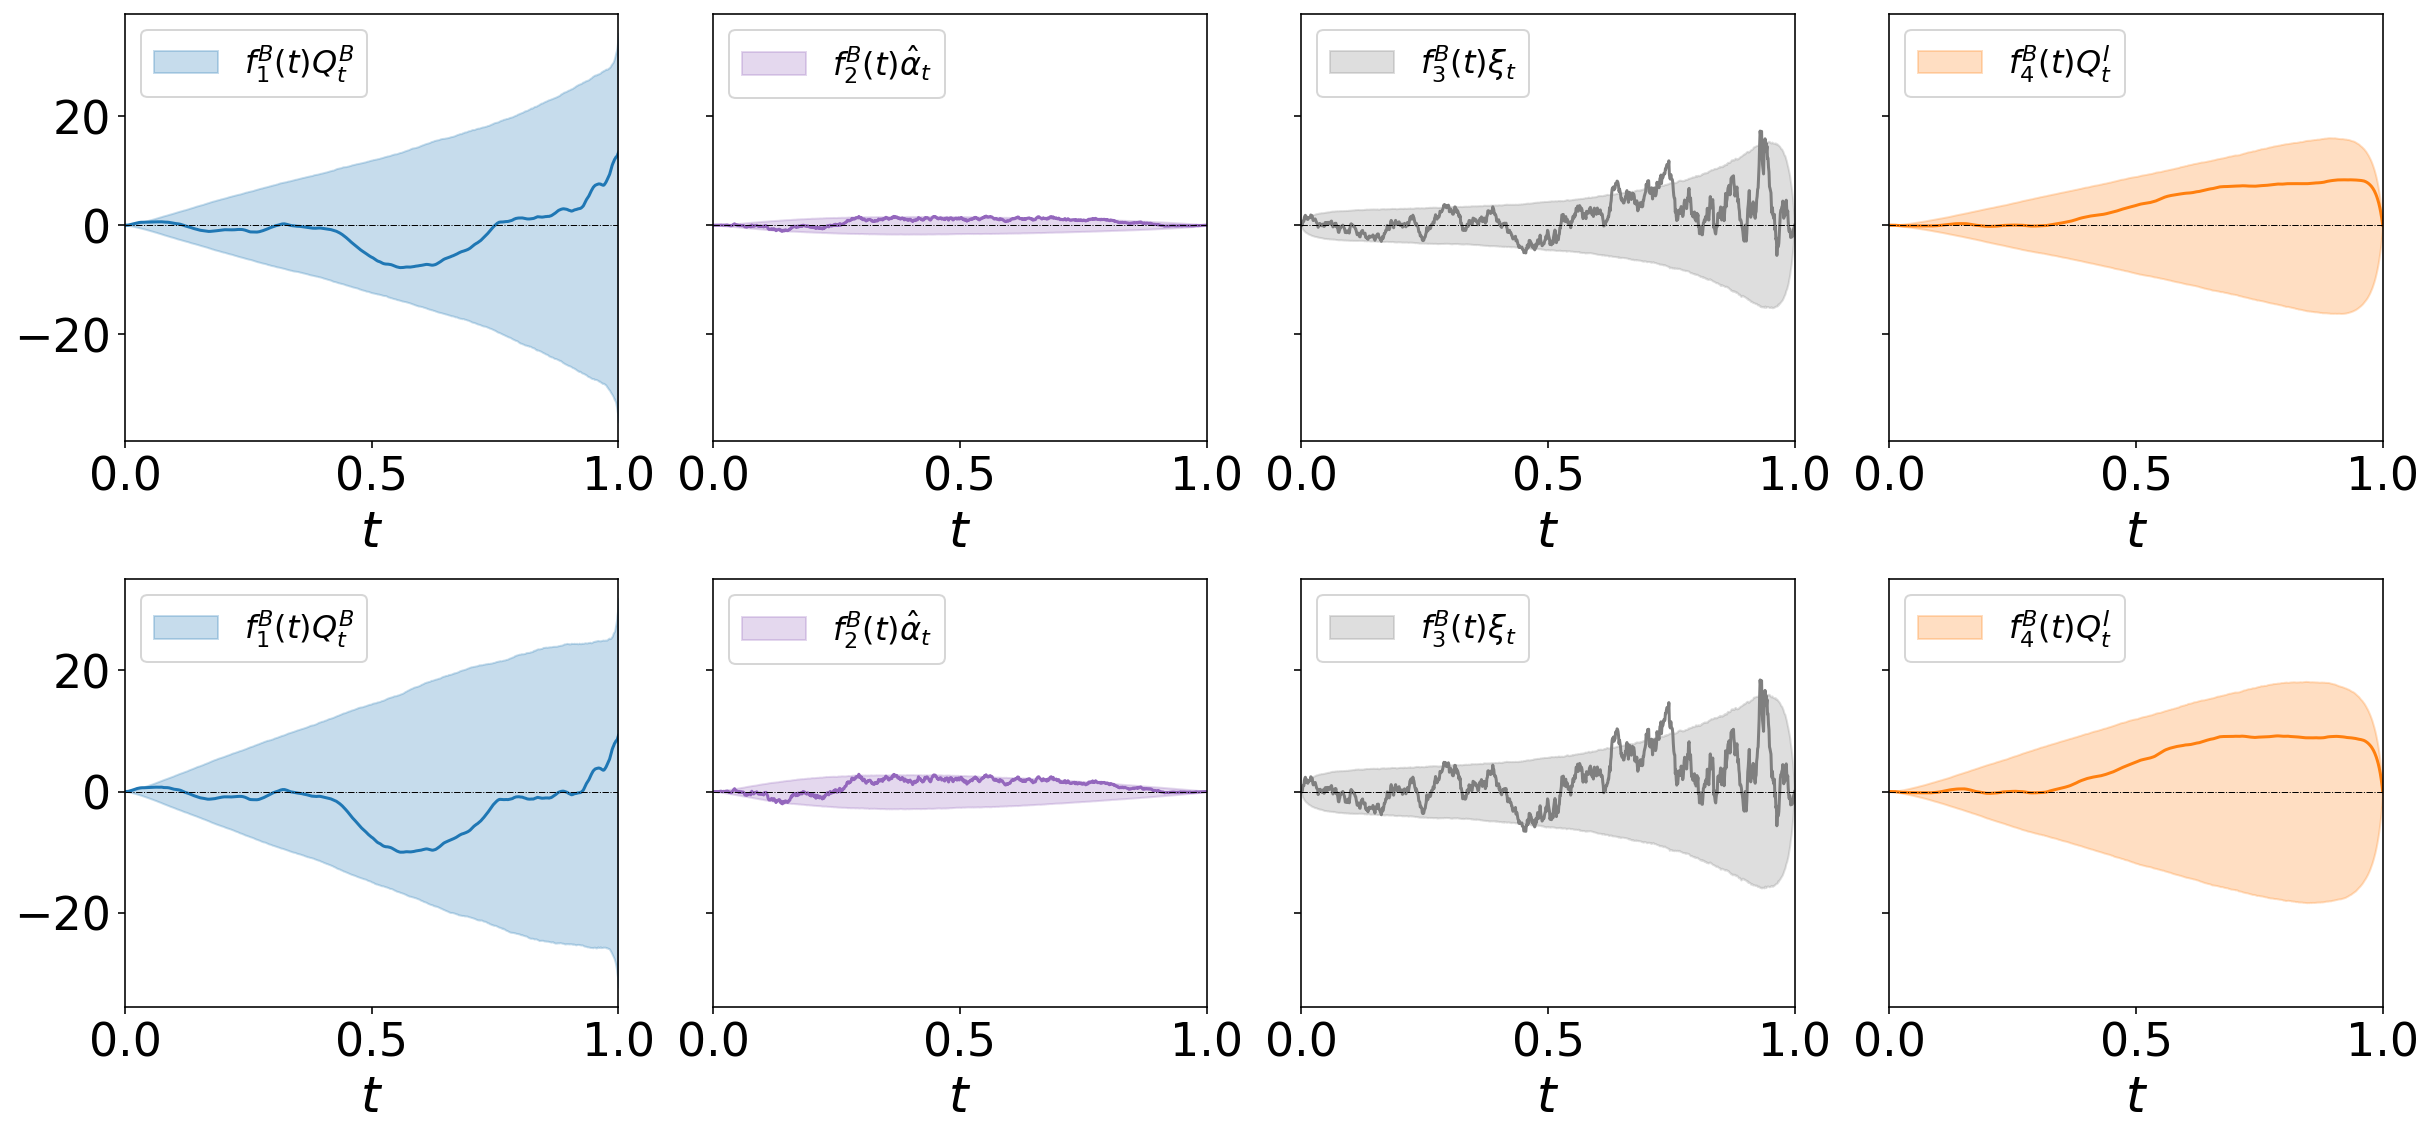

In [26]:
fig, ax = plt.subplots(2, 4, figsize=(17,8), sharey='row')
t = env.timesteps

for i, model in enumerate(sim_collections):
    
    broker = broker_collections[i]
    
    state_B = {1:(model.Q_B, r'$f_1^B(t)$', r'$Q_t^B$', 'tab:blue'), 
               2:(model.alpha_hat, r'$f_2^B(t)$', alpha_est_name[strategy_type], 'tab:purple'),
               3:(model.nu_U, r'$f_3^B(t)$', r'$\xi_t$', 'tab:gray'),
               4:(model.Q_I, r'$f_4^B(t)$', r'$Q_t^I$', 'tab:orange')}

    for j, (var_name, var_label_1, var_label_2, colour) in state_B.items():

        coef_var = broker.coef_speed_B[:, 0, j]
        var_name_qtl = np.quantile(var_name,[0.05,0.5,0.95], axis=1)

        nu_B_var = ((coef_var.reshape((-1,1)))@np.ones(shape=(1,nsims)))*var_name
        nu_B_var_qtl = np.quantile(nu_B_var,[0.05,0.5,0.95], axis=1)

        ax[i, j-1].fill_between(t,nu_B_var_qtl[0],nu_B_var_qtl[-1],alpha=0.25, label=var_label_1 + var_label_2, color=colour)
        ax[i, j-1].plot(t, nu_B_var[:,1], color=colour)
        ax[i, j-1].set_xlabel(r'$t$',fontsize=16)
        ax[i, j-1].legend(fontsize=16,loc='upper left')
        ax[i, j-1].set_xlim(0,1)
        ax[i, j-1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)

    ax[i, 0].set_xlabel(r'$t$', fontsize = font1)
    ax[i, 1].set_xlabel(r'$t$', fontsize = font1)
    ax[i, 2].set_xlabel(r'$t$', fontsize = font1)
    ax[i, 3].set_xlabel(r'$t$', fontsize = font1)

    ax[i, 0].tick_params(axis='both', which='major', labelsize=font2)
    ax[i, 1].tick_params(axis='both', which='major', labelsize=font2)
    ax[i, 2].tick_params(axis='both', which='major', labelsize=font2)
    ax[i, 3].tick_params(axis='both', which='major', labelsize=font2)
    
plt.tight_layout()
#plt.savefig(f'figures/nuB coef {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

(0.0, 1.0)

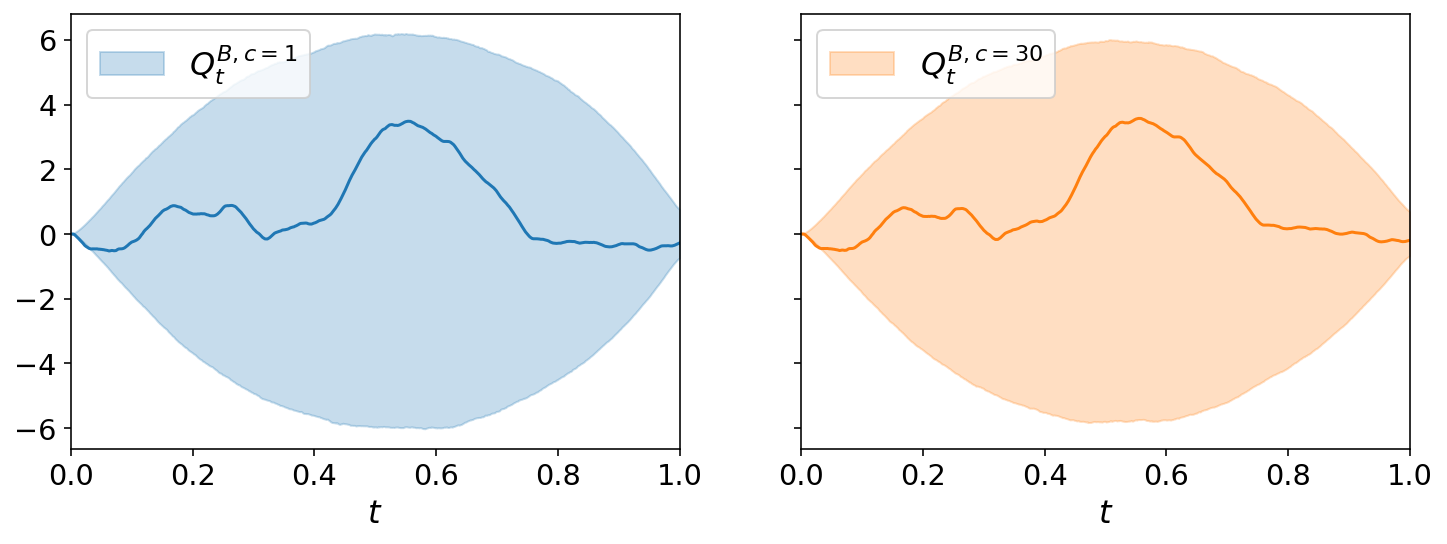

In [33]:
qtl_Q_B_1 = np.quantile(sim_collections[0].Q_B,[0.05,0.5,0.95], axis=1)
qtl_Q_B_2 = np.quantile(sim_collections[1].Q_B,[0.05,0.5,0.95], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey='row')

ax[0].fill_between(t,qtl_Q_B_1[0],qtl_Q_B_1[-1],alpha=0.25, label=r'$Q_t^{B, c= 1}$', color='tab:blue')
ax[1].fill_between(t,qtl_Q_B_2[0],qtl_Q_B_2[-1],alpha=0.25, label=r'$Q_t^{B, c= 30}$', color='tab:orange')
ax[0].plot(t, sim_collections[0].Q_B[:,1], markevery=100,color='tab:blue')
ax[1].plot(t, sim_collections[1].Q_B[:,1], markevery=100,color='tab:orange')
ax[0].set_xlabel(r'$t$',fontsize=16)
ax[0].legend(fontsize=16,loc='upper left')
ax[0].set_xlim(0,1)
ax[1].set_xlabel(r'$t$',fontsize=16)
ax[1].legend(fontsize=16,loc='upper left')
ax[1].set_xlim(0,1)

(0.0, 1.0)

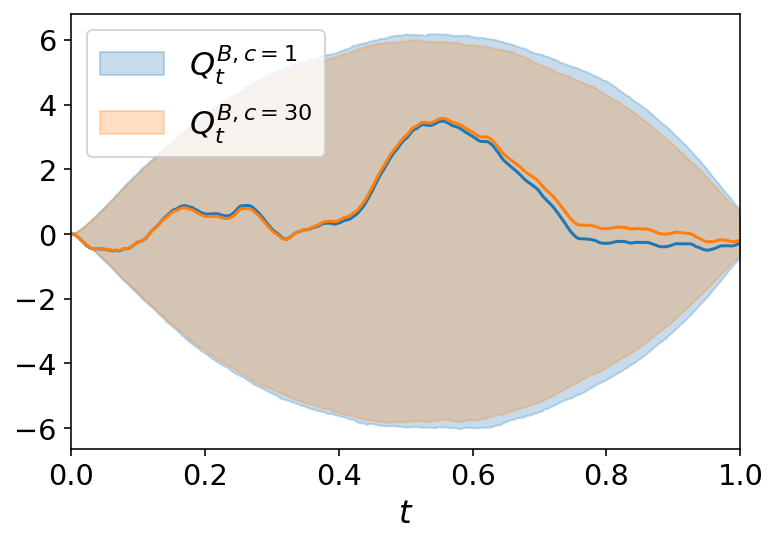

In [34]:
qtl_Q_B_1 = np.quantile(sim_collections[0].Q_B,[0.05,0.5,0.95], axis=1)
qtl_Q_B_2 = np.quantile(sim_collections[1].Q_B,[0.05,0.5,0.95], axis=1)

fig, ax = plt.subplots(1, 1, figsize=(6,4), sharey='row')

ax.fill_between(t,qtl_Q_B_1[0],qtl_Q_B_1[-1],alpha=0.25, label=r'$Q_t^{B, c= 1}$', color='tab:blue')
ax.fill_between(t,qtl_Q_B_2[0],qtl_Q_B_2[-1],alpha=0.25, label=r'$Q_t^{B, c= 30}$', color='tab:orange')
ax.plot(t, sim_collections[0].Q_B[:,1], markevery=100,color='tab:blue')
ax.plot(t, sim_collections[1].Q_B[:,1], markevery=100,color='tab:orange')
ax.set_xlabel(r'$t$',fontsize=16)
ax.legend(fontsize=16,loc='upper left')
ax.set_xlim(0,1)

In [31]:
nu_B_flatten_1 = sim_collections[0].nu_B.flatten()



Q_B_flatten_1 = sim_collections[0].Q_B.flatten()
alpha_hat_flatten_1 = sim_collections[0].alpha_hat.flatten()
nu_U_flatten_1 = sim_collections[0].nu_U.flatten()
Q_I_flatten_1 = sim_collections[0].Q_I.flatten()

Error in callback <function _draw_all_if_interactive at 0x000001E6BFE3E700> (for post_execute):


KeyboardInterrupt: 

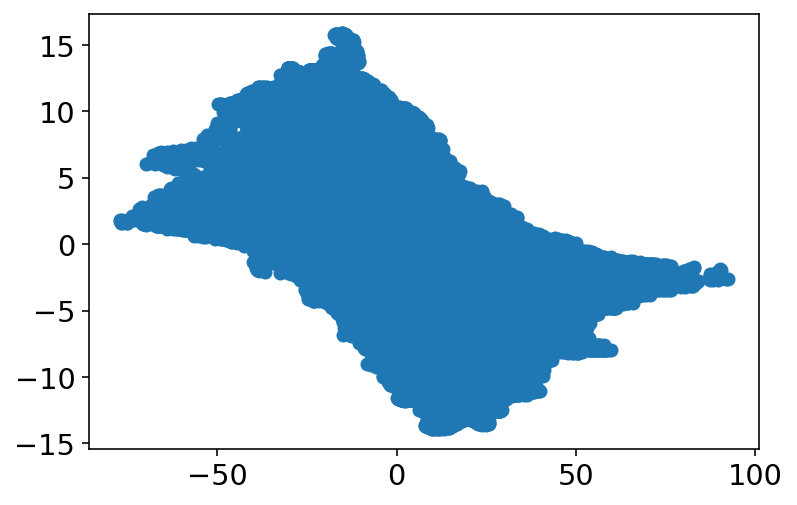

In [32]:
plt.scatter(nu_B_flatten_1, Q_B_flatten_1)

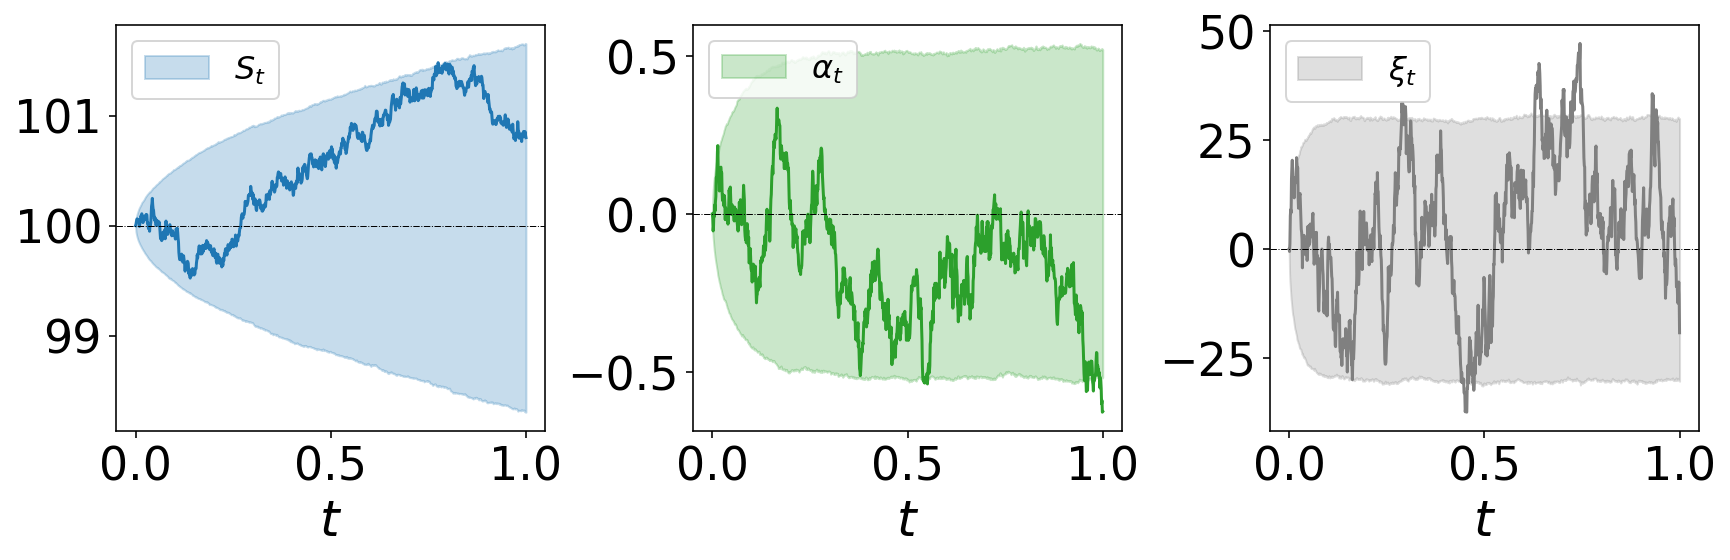

In [11]:
qtl_S = np.quantile(model.S,[0.05,0.5,0.95], axis=1)
qtl_alpha = np.quantile(alpha,[0.05,0.5,0.95], axis=1)
qtl_nu_U = np.quantile(nu_U,[0.05,0.5,0.95], axis=1)

t = env.timesteps

font1 = 25
font2 = 23
fig, ax = plt.subplots(1,3,figsize=(12,4))

ax[0].fill_between(t,qtl_S[0],qtl_S[-1],alpha=0.25, label=r'$S_t$', color='tab:blue')
ax[0].plot(t, model.S[:,1], markevery=100,color='tab:blue')
ax[0].legend(fontsize=16,loc='upper left')

ax[1].fill_between(t,qtl_alpha[0],qtl_alpha[-1],alpha=0.25, label=r'$\alpha_t$', color='tab:green')
ax[1].plot(t, alpha[:,1], markevery=100,color='tab:green')
ax[1].legend(fontsize=16,loc='upper left')

ax[2].fill_between(t,qtl_nu_U[0],qtl_nu_U[-1],alpha=0.25, label=r'$\xi_t$', color='gray')
ax[2].plot(t, nu_U[:,1], markevery=100,color='gray')
ax[2].legend(fontsize=16,loc='upper left')

ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)

ax[0].axhline(env.S0, linestyle='-.', color = 'black', linewidth=0.5)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
ax[2].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)

plt.tight_layout()
plt.savefig(f'figures/env {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

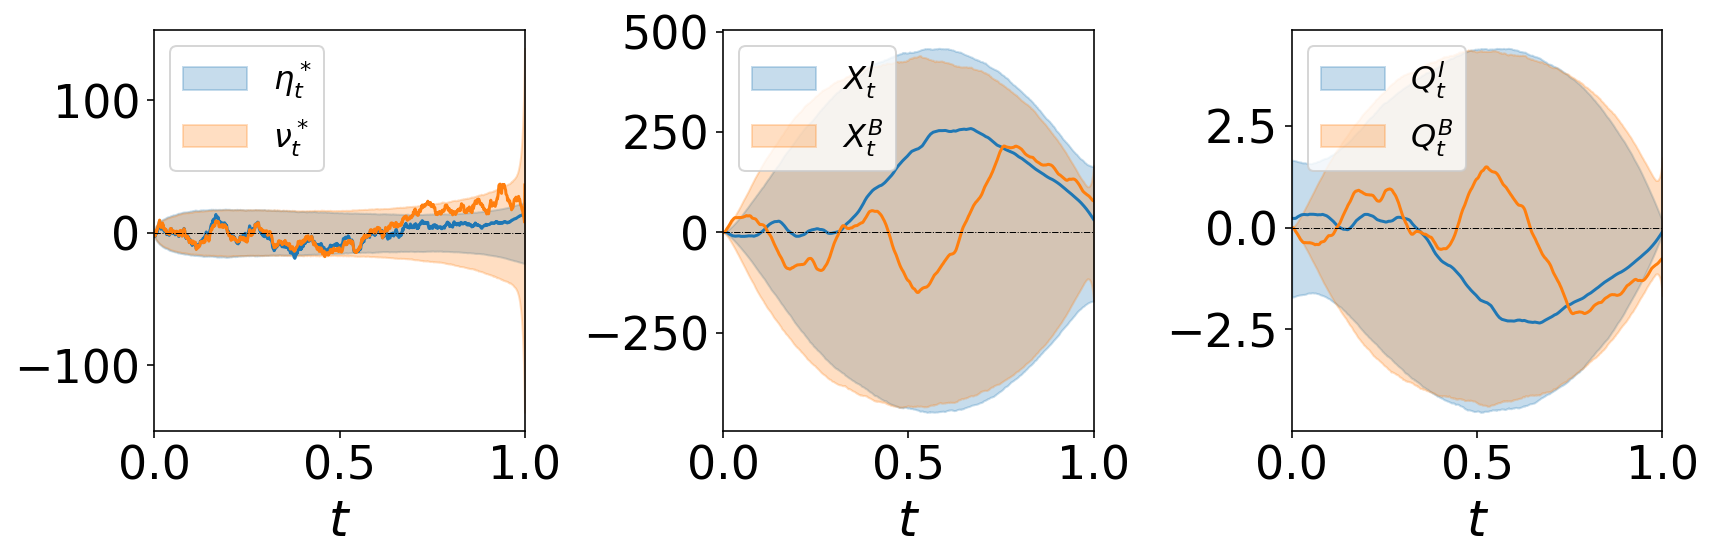

In [12]:
# informed & broker's speed

t = env.timesteps

fig, ax = plt.subplots(1, 3, figsize=(12,4))
font1 = 25
font2 = 23

qtl_nu_I = np.quantile(model.nu_I,[0.05,0.5,0.95], axis=1)
qtl_nu_B = np.quantile(model.nu_B,[0.05,0.5,0.95], axis=1)

qtl_X_I = np.quantile(model.X_I,[0.05,0.5,0.95], axis=1)
qtl_X_B = np.quantile(model.X_B,[0.05,0.5,0.95], axis=1)

qtl_Q_I = np.quantile(model.Q_I,[0.05,0.5,0.95], axis=1)
qtl_Q_B = np.quantile(model.Q_B,[0.05,0.5,0.95], axis=1)

ax[0].fill_between(t,qtl_nu_I[0],qtl_nu_I[-1],alpha=0.25, label=r'$\eta_t^*$', color='tab:blue')
ax[0].fill_between(t,qtl_nu_B[0],qtl_nu_B[-1],alpha=0.25, label=r'$\nu_t^*$', color='tab:orange')
ax[0].plot(t, model.nu_I[:,1], markevery=100,color='tab:blue')
ax[0].plot(t, model.nu_B[:,1], markevery=100,color='tab:orange')
ax[0].set_xlabel(r'$t$',fontsize=16)
ax[0].legend(fontsize=16,loc='upper left')
ax[0].set_xlim(0.,1)

ax[1].fill_between(t,qtl_X_I[0],qtl_X_I[-1],alpha=0.25, label=r'$X_t^I$', color='tab:blue')
ax[1].fill_between(t,qtl_X_B[0],qtl_X_B[-1],alpha=0.25, label=r'$X_t^B$', color='tab:orange')
ax[1].plot(t, model.X_I[:,1], markevery=100,color='tab:blue')
ax[1].plot(t, model.X_B[:,1], markevery=100,color='tab:orange')
ax[1].set_xlabel(r'$t$',fontsize=16)
ax[1].legend(fontsize=16,loc='upper left')
ax[1].set_xlim(0,1)

ax[2].fill_between(t,qtl_Q_I[0],qtl_Q_I[-1],alpha=0.25, label=r'$Q_t^I$', color='tab:blue')
ax[2].fill_between(t,qtl_Q_B[0],qtl_Q_B[-1],alpha=0.25, label=r'$Q_t^B$', color='tab:orange')
ax[2].plot(t, model.Q_I[:,1], markevery=100,color='tab:blue')
ax[2].plot(t, model.Q_B[:,1], markevery=100,color='tab:orange')
ax[2].set_xlabel(r'$t$',fontsize=16)
ax[2].legend(fontsize=16,loc='upper left')
ax[2].set_xlim(0,1)

ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)

ax[0].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
ax[2].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)

plt.tight_layout()
plt.savefig(f'figures/speed cash inventory {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

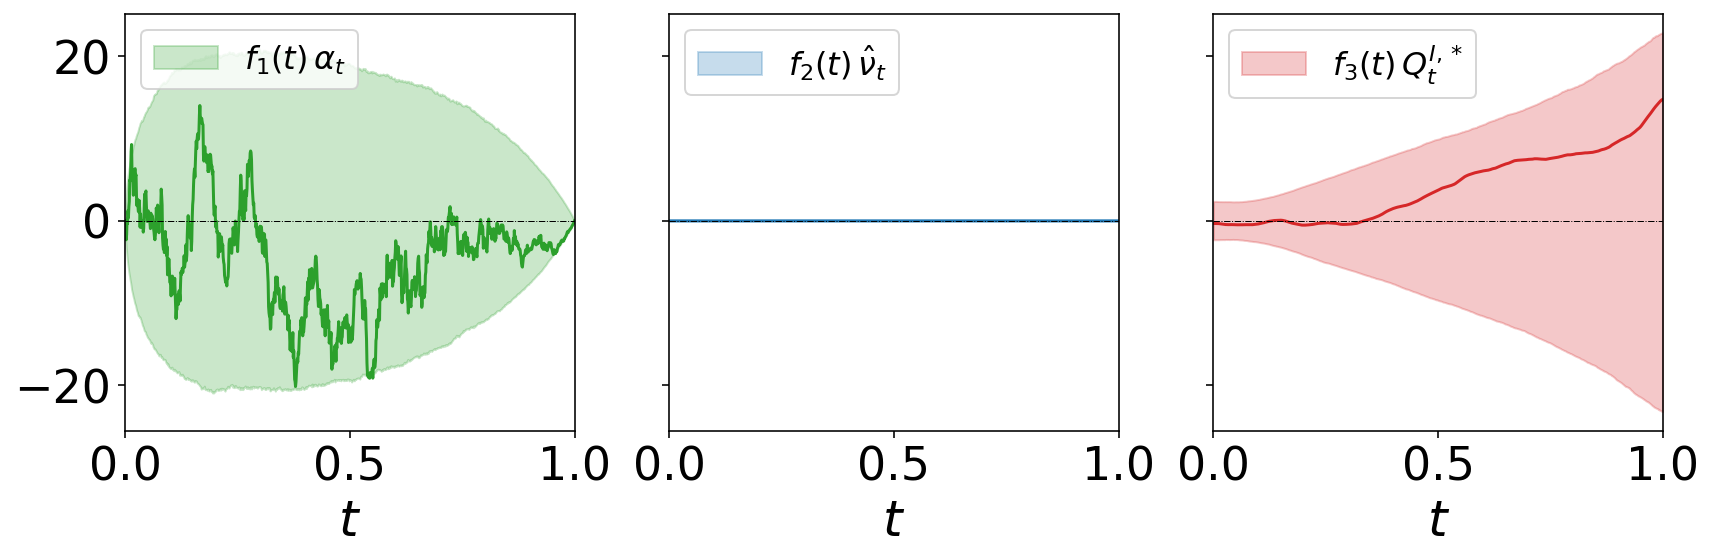

In [13]:
# plot the components of trader's speed

t = env.timesteps

fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey='row')

z = inf_trader.z
f3 = z[9] / inf_trader.k
f2 = z[2] / 2 / inf_trader.k
f1 = z[1] / 2 / inf_trader.k
f0 = z[0] / 2 / inf_trader.k

nu_I_0 = f0
nu_I_alpha = ((f1.reshape((-1,1)))@np.ones(shape=(1,nsims)))*model.alpha
nu_I_nu_B_hat = ((f2.reshape((-1,1)))@np.ones(shape=(1,nsims)))*model.nu_B_hat
nu_I_Q_I = ((f3.reshape((-1,1)))@np.ones(shape=(1,nsims)))*model.Q_I

nu_I_alpha_qtl = np.quantile(nu_I_alpha,[0.05,0.5,0.95], axis=1)
nu_I_nu_B_hat_qtl = np.quantile(nu_I_nu_B_hat,[0.05,0.5,0.95], axis=1)
nu_I_Q_I_qtl = np.quantile(nu_I_Q_I,[0.05,0.5,0.95], axis=1)

nu_B_hat_qtl = np.quantile(model.nu_B_hat,[0.05,0.5,0.95], axis=1)
alpha_qtl = np.quantile(model.alpha,[0.05,0.5,0.95], axis=1)
Q_I_qtl = np.quantile(model.Q_I,[0.05,0.5,0.95], axis=1)

ax[0].fill_between(t,nu_I_alpha_qtl[0],nu_I_alpha_qtl[-1], alpha=0.25, label=r'$f_1(t)\, \alpha_t$', color='tab:green')
ax[0].plot(t, nu_I_alpha[:,1], markevery=100, color='tab:green')
ax[0].set_xlabel(r'$t$',fontsize=16)
ax[0].legend(fontsize=16,loc='upper left')
ax[0].set_xlim(0,1)
ax[0].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
#ax[1,1].set_ylim(y_lim_1)

ax[1].fill_between(t,nu_I_nu_B_hat_qtl[0],nu_I_nu_B_hat_qtl[-1], alpha=0.25, label=r'$f_2(t)\, \hat{\nu}_t$', color='tab:blue')
ax[1].plot(t, nu_I_nu_B_hat[:,1], markevery=100, color='tab:blue')
ax[1].set_xlabel(r'$t$',fontsize=16)
ax[1].legend(fontsize=16,loc='upper left')
ax[1].set_xlim(0,1)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
#ax[1,2].set_ylim(y_lim_1)

ax[2].fill_between(t,nu_I_Q_I_qtl[0],nu_I_Q_I_qtl[-1], alpha=0.25, label=r'$f_3(t)\, Q_t^{I,*}$', color='tab:red')
ax[2].plot(t, nu_I_Q_I[:,1], markevery=100, color='tab:red')
ax[2].set_xlabel(r'$t$',fontsize=16)
ax[2].legend(fontsize=16,loc='upper left')
ax[2].set_xlim(0,1)
ax[2].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
#ax[1,3].set_ylim(y_lim_1)


ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)


plt.tight_layout()
plt.savefig(f'figures/nuI coef {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

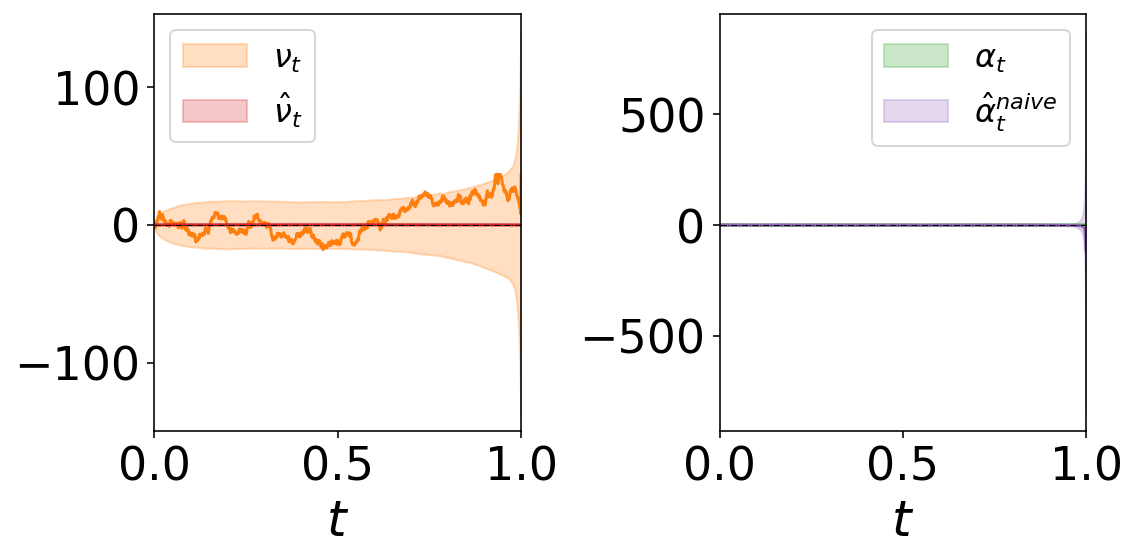

In [14]:
t = env.timesteps
sim = 1
fig, ax = plt.subplots(1, 2, figsize=(8,4))

qtl_alpha = np.quantile(model.alpha,[0.05,0.5,0.95], axis=1)
qtl_alpha_hat = np.quantile(model.alpha_hat,[0.05,0.5,0.95], axis=1)

qtl_nu_B = np.quantile(model.nu_B,[0.05,0.5,0.95], axis=1)
qtl_nu_B_hat = np.quantile(model.nu_B_hat,[0.05,0.5,0.95], axis=1)

ax[0].fill_between(t,qtl_nu_B[0],qtl_nu_B[-1],alpha=0.25, label=r'$\nu_t$', color='tab:orange')
ax[0].fill_between(t,qtl_nu_B_hat[0],qtl_nu_B_hat[-1],alpha=0.25, label=r'$\hat{\nu}_t$', color='tab:red')
ax[0].plot(t, model.nu_B[:,sim], markevery=100,color='tab:orange')
ax[0].plot(t, model.nu_B_hat[:,sim], markevery=100,color='tab:red')
ax[0].set_xlabel(r'$t$',fontsize=16)
ax[0].legend(fontsize=16,loc='upper left')
ax[0].set_xlim(0,1)
#plt.ylim(-4,4)

ax[1].fill_between(t,qtl_alpha[0],qtl_alpha[-1],alpha=0.25, label=r'$\alpha_t$', color='tab:green')
ax[1].plot(t, model.alpha[:,1], markevery=100,color='tab:green')
ax[1].fill_between(t,qtl_alpha_hat[0],qtl_alpha_hat[-1],alpha=0.25, label=alpha_est_name[strategy_type], color='tab:purple')
ax[1].plot(t, model.alpha_hat[:,1], markevery=100,color='tab:purple')
ax[1].set_xlabel(r'$t$',fontsize=16)
ax[1].legend(fontsize=16,loc='upper right')
ax[1].set_xlim(0,1)

ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)

ax[0].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
ax[1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)

plt.tight_layout()
plt.savefig(f'figures/filtering {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [15]:
state_B = {1:(model.Q_B, r'$f_1^B(t)$', r'$Q_t^B$', 'tab:blue'), 
           2:(model.alpha_hat, r'$f_2^B(t)$', alpha_est_name[strategy_type], 'tab:purple'),
           3:(model.nu_U, r'$f_3^B(t)$', r'$\xi_t$', 'tab:gray'),
           4:(model.Q_I, r'$f_4^B(t)$', r'$Q_t^I$', 'tab:orange')}

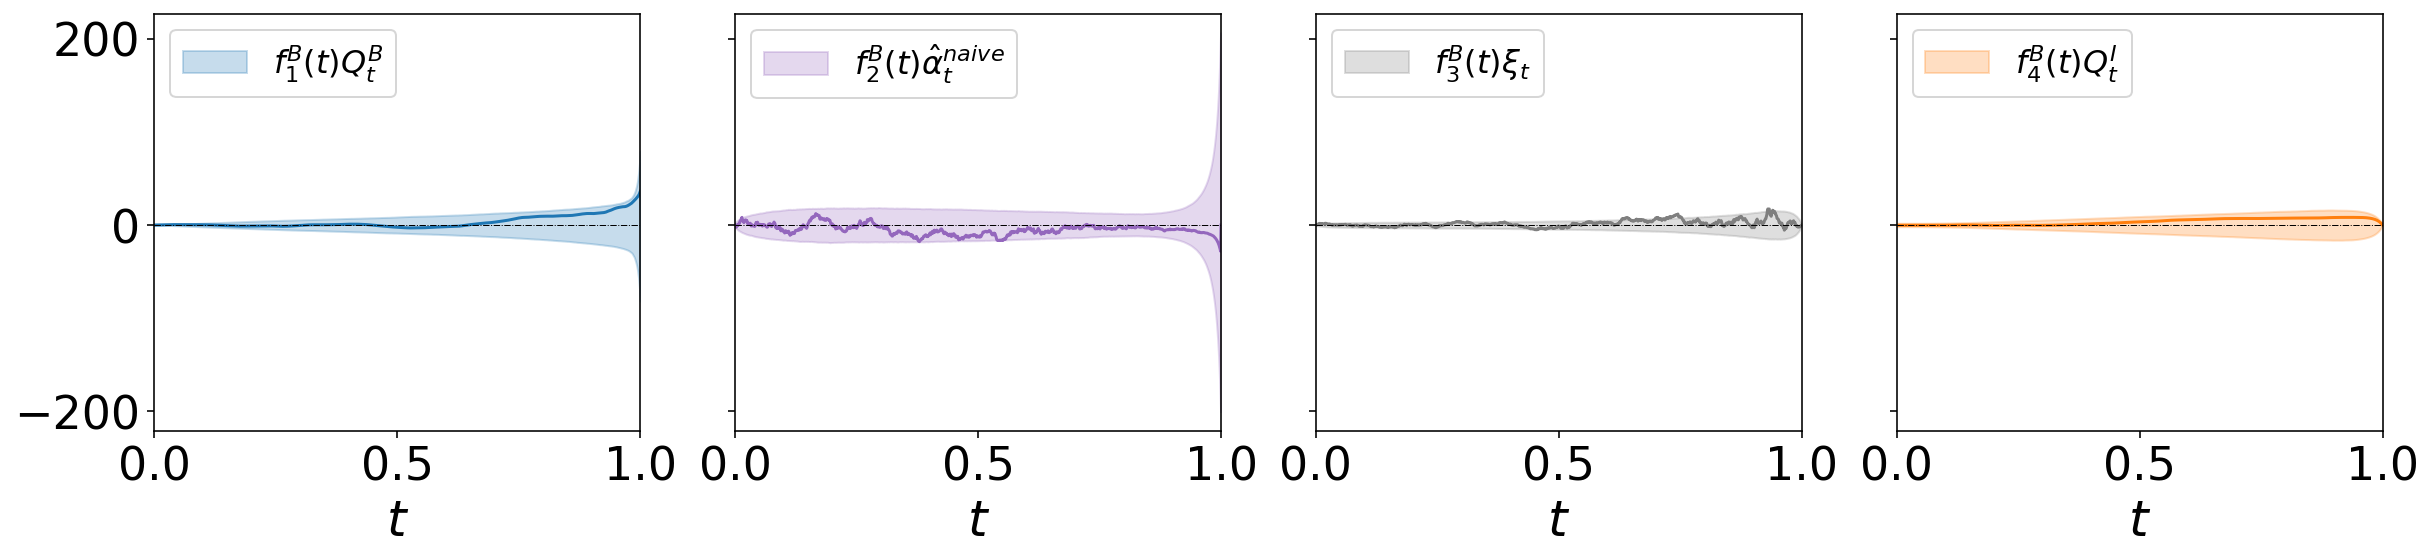

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(17,4), sharey='row')
t = env.timesteps

for j, (var_name, var_label_1, var_label_2, colour) in state_B.items():
    
    coef_var = broker.coef_speed_B[:, 0, j]
    var_name_qtl = np.quantile(var_name,[0.05,0.5,0.95], axis=1)
    
    nu_B_var = ((coef_var.reshape((-1,1)))@np.ones(shape=(1,nsims)))*var_name
    nu_B_var_qtl = np.quantile(nu_B_var,[0.05,0.5,0.95], axis=1)
    
    ax[j-1].fill_between(t,nu_B_var_qtl[0],nu_B_var_qtl[-1],alpha=0.25, label=var_label_1 + var_label_2, color=colour)
    ax[j-1].plot(t, nu_B_var[:,1], color=colour)
    ax[j-1].set_xlabel(r'$t$',fontsize=16)
    ax[j-1].legend(fontsize=16,loc='upper left')
    ax[j-1].set_xlim(0,1)
    ax[j-1].axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
    
ax[0].set_xlabel(r'$t$', fontsize = font1)
ax[1].set_xlabel(r'$t$', fontsize = font1)
ax[2].set_xlabel(r'$t$', fontsize = font1)
ax[3].set_xlabel(r'$t$', fontsize = font1)

ax[0].tick_params(axis='both', which='major', labelsize=font2)
ax[1].tick_params(axis='both', which='major', labelsize=font2)
ax[2].tick_params(axis='both', which='major', labelsize=font2)
ax[3].tick_params(axis='both', which='major', labelsize=font2)
    
plt.tight_layout()
plt.savefig(f'figures/nuB coef {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

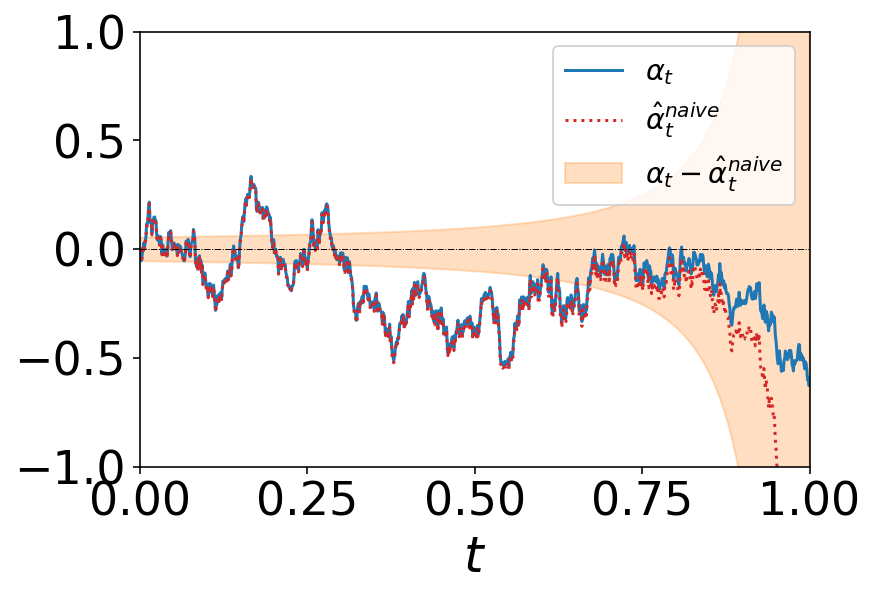

In [17]:
sim_num = 1

alpha_diff = model.alpha - model.alpha_hat
qtl_alpha_diff = np.quantile(alpha_diff,[0.05,0.5,0.95], axis=1)

plt.plot(env.timesteps[:], model.alpha[:, sim_num], label=r'$\alpha_t$')
plt.plot(env.timesteps[:], model.alpha_hat[:, sim_num], label=alpha_est_name[strategy_type], color='tab:red', linestyle = ':')
plt.fill_between(env.timesteps[:], qtl_alpha_diff[0],qtl_alpha_diff[-1],alpha=0.25, label=(r'$\alpha_t - $' + alpha_est_name[strategy_type]), color='tab:orange')
plt.axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
plt.xlim(0,1)

y_ax = 1
plt.ylim(-y_ax,y_ax)
plt.xlabel(r'$t$', fontsize = font1)
plt.tick_params(axis='both', which='major', labelsize=font2)
plt.legend()
plt.savefig(f'figures/alpha {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

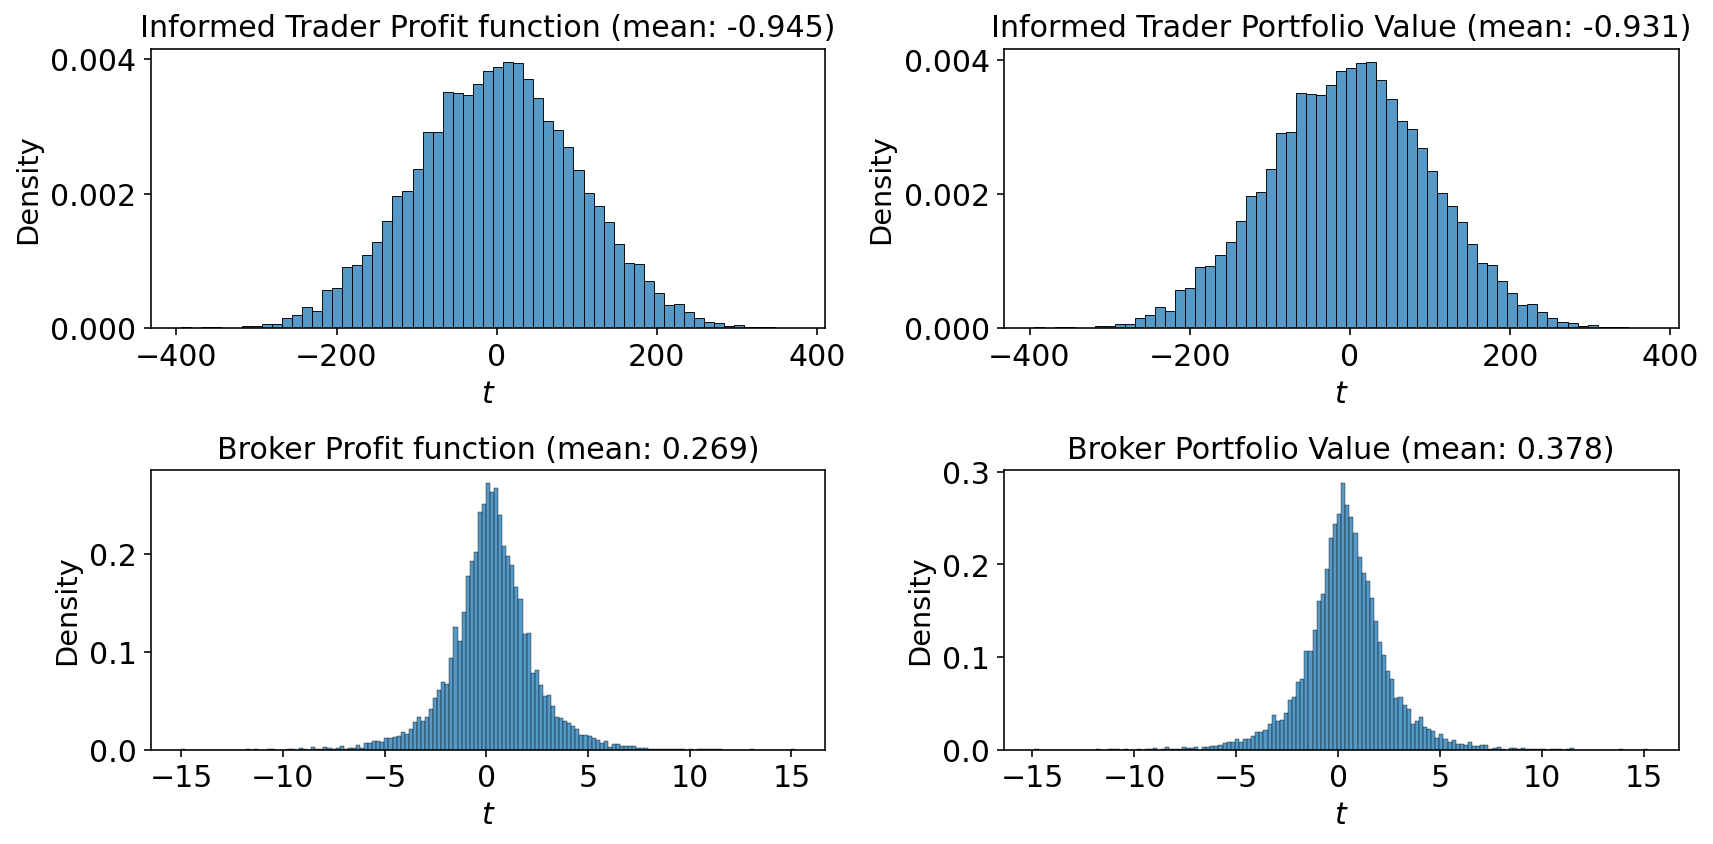

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(12,6))
t = env.timesteps

font3 = 15

sns.histplot(model.H_I[0,:], stat='density', ax=ax[0, 0])
ax[0, 0].set_title(f'Informed Trader Profit function (mean: {model.H_I[0,:].mean():.3f})', fontsize=font3)

sns.histplot(model.H_B[0,:], stat='density', ax=ax[1, 0])
ax[1, 0].set_title(f'Broker Profit function (mean: {model.H_B[0,:].mean():.3f})', fontsize=font3)

sns.histplot(model.Portfolio_I, stat='density', ax=ax[0, 1])
ax[0, 1].set_title(f'Informed Trader Portfolio Value (mean: {model.Portfolio_I.mean():.3f})', fontsize=font3)

sns.histplot(model.Portfolio_B, stat='density', ax=ax[1, 1])
ax[1, 1].set_title(f'Broker Portfolio Value (mean: {model.Portfolio_B.mean():.3f})', fontsize=font3)

for axes in ax.reshape(-1):
    axes.set_xlabel(r'$t$', fontsize = font3)
    axes.tick_params(axis='both', which='major', labelsize=font3)

plt.tight_layout()
plt.show()

## 6. Compute the outperformance & test whether it outperforms the benchmark

T-test for outperformance w.r.t benchmark 1
T statistic: 11.445936063462314
P-value: 1.8977399358088097e-30 

T-test for outperformance w.r.t benchmark 2
T statistic: 13.129825002890092
P-value: 2.335593233670325e-39 

T-test for outperformance w.r.t benchmark 3
T statistic: 20.850638346535636
P-value: 7.588627030650785e-95 



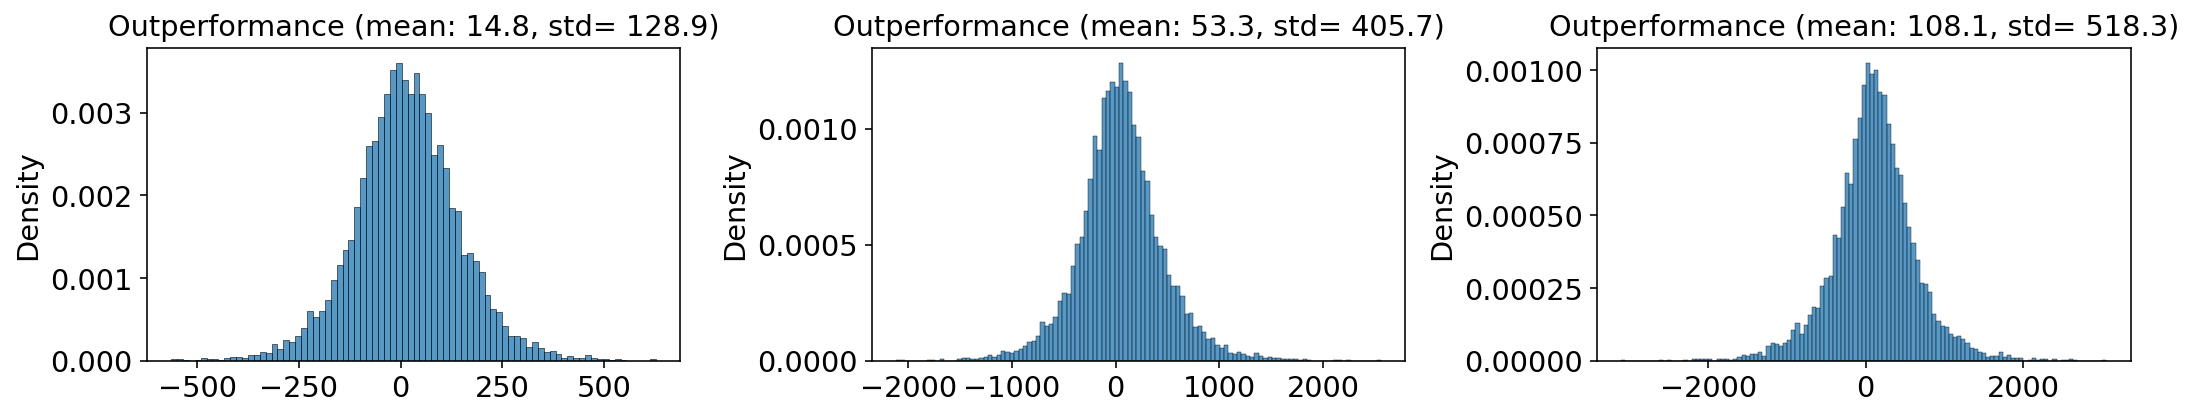

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
t = env.timesteps

benchmarks = dict.fromkeys([f'benchmark {i+1}' for i in range(3)])
outperform = dict.fromkeys([f'benchmark {i+1}' for i in range(3)])

for i, bench in enumerate(benchmarks.keys()):
    benchmarks[bench] = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                                               W, alpha, nu_U, 
                                               strategy = bench, mispecify = mispecify, mispecify_scale = 1, nsims = nsims)
    outperform[bench] = 1e06*((model.Portfolio_B - benchmarks[bench].Portfolio_B)/benchmarks[bench].total_value_traded).reshape((-1,))
    sns.histplot(outperform[bench], stat='density', ax=ax[i])
    ax[i].set_title(f'Outperformance (mean: {outperform[bench].mean():.1f}, std= {outperform[bench].std():.1f})')
    
    t_stat, p_value = stats.ttest_1samp(outperform[bench], 0, alternative='greater')
    print(f"T-test for outperformance w.r.t benchmark {i+1}")
    print("T statistic:", t_stat)
    print("P-value:", p_value, "\n")
    
plt.tight_layout()
plt.savefig(f'figures/outperform {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

## 7. Plot the quality of the alpha filter

In [20]:
var_alpha_obs = (1/(nsims-1))*np.diag((model.alpha - model.alpha_hat)@((model.alpha - model.alpha_hat).T))

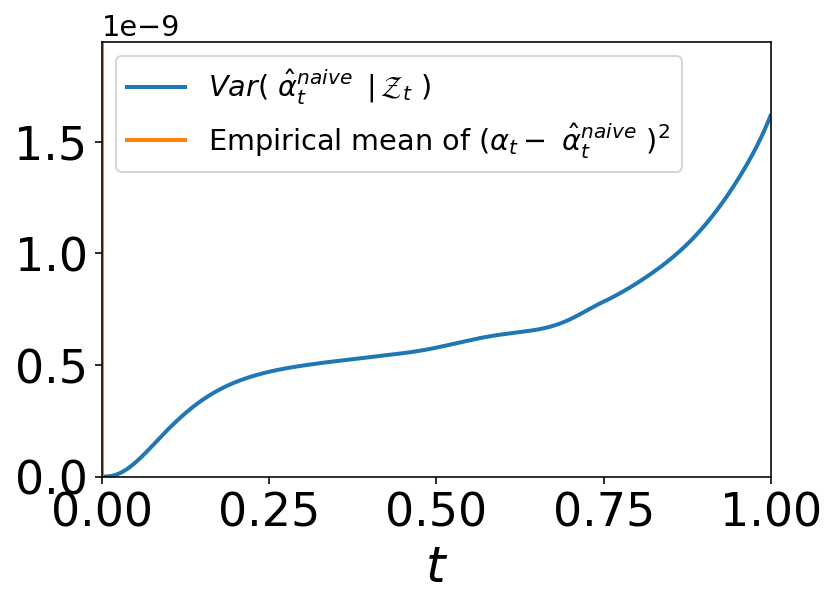

In [21]:
stepback = 1

plt.plot(env.timesteps[:-stepback], model.V_B[:-stepback], label=r'$Var($ ' + alpha_est_name[strategy_type] + r' $\, |\, \mathcal{Z}_t$ )', linewidth=2)
plt.plot(env.timesteps[:-stepback], var_alpha_obs[:-stepback], label=rf'Empirical mean of $(\alpha_t - $ {alpha_est_name[strategy_type]} $)^2$', linewidth=2)
plt.legend()
plt.xlabel(r'$t$', fontsize = font1)
plt.tick_params(axis='both', which='major', labelsize=font2)
plt.xlim(0,1)
plt.ylim(0,1.2*model.V_B[-1])
plt.show()

## 8. Comparing the alternative optimal filter to naive filter

In [74]:
mispecify_1 = False

alt_filter = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                               W, alpha, nu_U, 
                               strategy = "alternative filter", mispecify = mispecify_1, mispecify_scale = 1, nsims = nsims)

naive_filter = simulations.simulation(env, inf_trader, uninf_trader, broker, 
                               W, alpha, nu_U, 
                               strategy = "naive filter", mispecify = mispecify_1, mispecify_scale = 1, nsims = nsims)

C:\Users\muham\[Broker, Informed, Noise Traders, Filtering Game]\simulations.py:114: RuntimeWarning: divide by zero encountered in divide
  self.Z_tilde[i+1, :] = self.gamma_tilde[i+1, :]/broker.GF5[i+1]
C:\Users\muham\[Broker, Informed, Noise Traders, Filtering Game]\simulations.py:114: RuntimeWarning: invalid value encountered in divide
  self.Z_tilde[i+1, :] = self.gamma_tilde[i+1, :]/broker.GF5[i+1]


T-test for outperformance of alternative optimal filter to naive filter
T statistic: -2.783922551536828
P-value: 0.997309662618306 



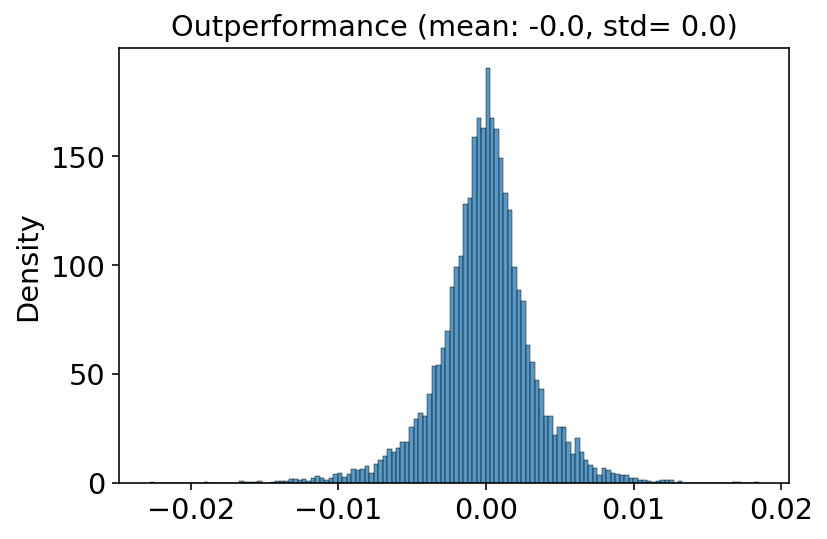

In [75]:
outperform_alt_to_naive = 1e06*((alt_filter.Portfolio_B - naive_filter.Portfolio_B)/naive_filter.total_value_traded).reshape((-1,))
sns.histplot(outperform_alt_to_naive, stat='density')
plt.title(f'Outperformance (mean: {outperform_alt_to_naive.mean():.1f}, std= {outperform_alt_to_naive.std():.1f})')

t_stat, p_value = stats.ttest_1samp(outperform_alt_to_naive, 0, alternative='greater')
print(f"T-test for outperformance of alternative optimal filter to naive filter")
print("T statistic:", t_stat)
print("P-value:", p_value, "\n")

## Plotting the difference of the filters

In [76]:
alpha_diff = alt_filter.alpha_hat - naive_filter.alpha_hat

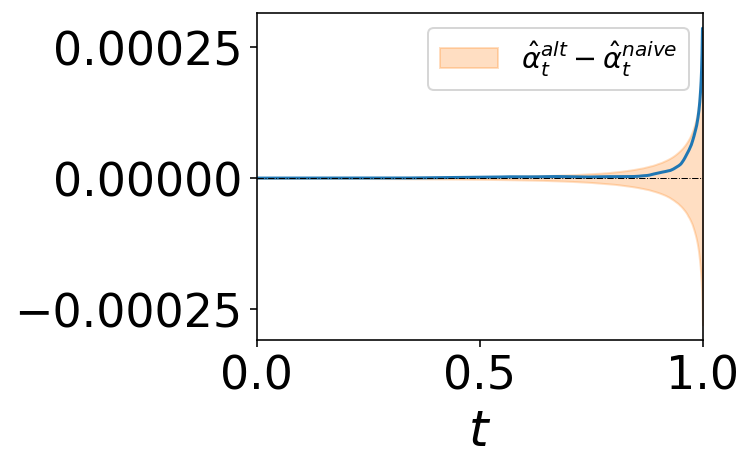

In [79]:
sim_num = 1

qtl_alpha_diff = np.quantile(alpha_diff,[0.05,0.5,0.95], axis=1)

plt.figure(figsize=(4,3))
plt.plot(env.timesteps[:], alpha_diff[:, sim_num])
plt.fill_between(env.timesteps[:], qtl_alpha_diff[0],qtl_alpha_diff[-1],alpha=0.25, label=r'$\hat{\alpha}^{alt}_t - \hat{\alpha}^{naive}_t$', color='tab:orange')
plt.axhline(0, linestyle='-.', color = 'black', linewidth=0.5)
plt.xlim(0,1)

#plt.ylim(-1e-5,1e-5)
plt.xlabel(r'$t$', fontsize = font1)
plt.tick_params(axis='both', which='major', labelsize=font2)
plt.legend()
plt.savefig(f'figures/alpha diff {file_name}.pdf',format='pdf',bbox_inches='tight')
plt.show()

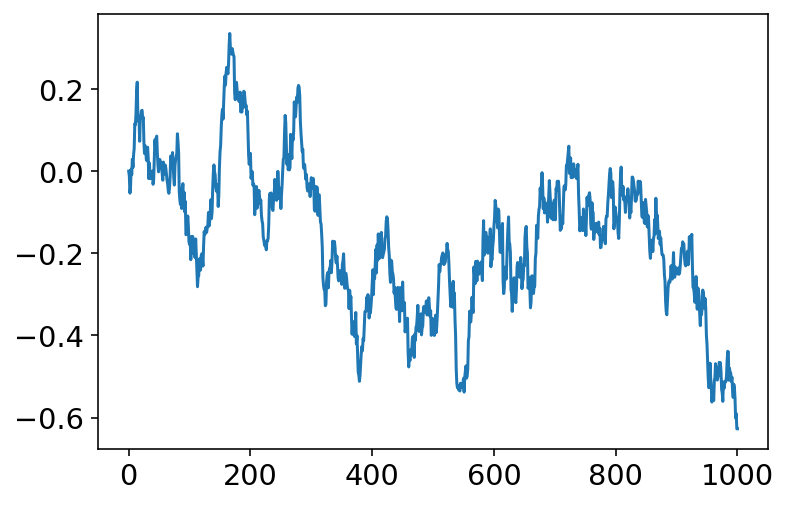

In [34]:
plt.plot(naive_filter.alpha_hat[:,1])

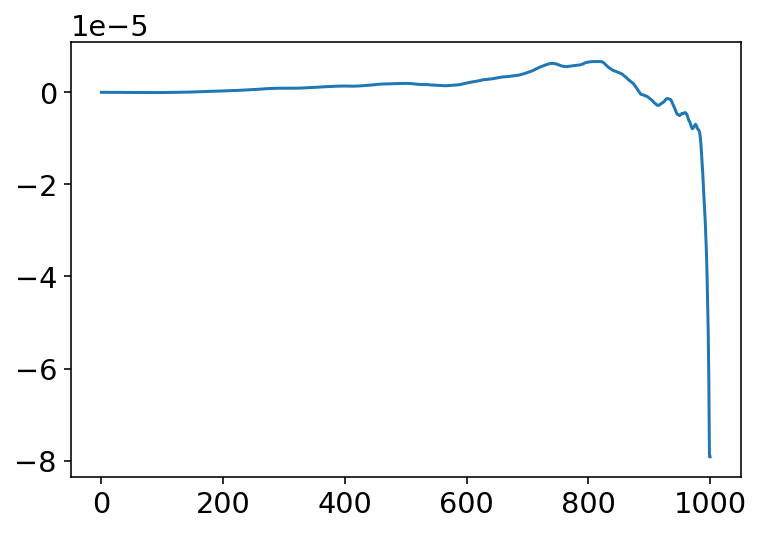

In [42]:
plt.plot(alph_diff[:,3])